In [1]:
# Import libraries
from sdv.single_table import (
    CopulaGANSynthesizer, CTGANSynthesizer, GaussianCopulaSynthesizer, TVAESynthesizer)
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from torch.nn import functional as F
import logging
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.preprocessing import KBinsDiscretizer
import sdgym
from sdv.metadata.single_table import SingleTableMetadata
from sdgym.datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
import rdt
from rdt.transformers import AnonymizedFaker, IDGenerator, RegexGenerator, get_default_transformers
from copy import deepcopy
import inspect
import copy
import traceback
import importlib
from pathlib import Path
from rdt.transformers.pii.anonymization import get_anonymized_transformer
import warnings
import sys
from pandas.core.tools.datetimes import _guess_datetime_format_for_array
from pandas.api.types import is_float_dtype, is_integer_dtype
import json
import datetime
import pkg_resources
import cloudpickle
import os
from collections import defaultdict
import uuid
import math
from copulas.multivariate import GaussianMultivariate
from tqdm import tqdm as tqdm1
from tqdm import tqdm as tqdm2
import functools
import copulas
from ctgan import CTGAN
from sdgym import create_single_table_synthesizer
from joblib import Parallel, delayed
from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder
from collections import namedtuple
import contextlib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from table_evaluator import TableEvaluator
from scipy.spatial.distance import cdist
from rdt import HyperTransformer

In [2]:
# CTGAN DataProcessor
class DataProcessor:
    """Single table data processor.

    This class handles all pre and post processing that is done to a single table to get it ready
    for modeling and finalize sampling. These processes include formatting, transformations,
    anonymization and constraint handling.

    Args:
        metadata (metadata.SingleTableMetadata):
            The single table metadata instance that will be used to apply constraints and
            transformations to the data.
        enforce_rounding (bool):
            Define rounding scheme for FloatFormatter. If True, the data returned by
            reverse_transform will be rounded to that place. Defaults to True.
        enforce_min_max_values (bool):
            Specify whether or not to clip the data returned by reverse_transform of the numerical
            transformer, FloatFormatter, to the min and max values seen during fit.
            Defaults to True.
        model_kwargs (dict):
            Dictionary specifying the kwargs that need to be used in each tabular
            model when working on this table. This dictionary contains as keys the name of the
            TabularModel class and as values a dictionary containing the keyword arguments to use.
            This argument exists mostly to ensure that the models are fitted using the same
            arguments when the same DataProcessor is used to fit different model instances on
            different slices of the same table.
        table_name (str):
            Name of table this processor is for. Optional.
        locales (str or list):
            Default locales to use for AnonymizedFaker transformers. Optional, defaults to using
            Faker's default locale.
    """

    _DTYPE_TO_SDTYPE = {
        'i': 'numerical',
        'f': 'numerical',
        'O': 'categorical',
        'b': 'boolean',
        'M': 'datetime',
    }

    _COLUMN_RELATIONSHIP_TO_TRANSFORMER = {
        'address': 'RandomLocationGenerator',
    }

    def _update_numerical_transformer(self, enforce_rounding, enforce_min_max_values):
        custom_float_formatter = rdt.transformers.FloatFormatter(
            missing_value_replacement='mean',
            missing_value_generation='random',
            learn_rounding_scheme=enforce_rounding,
            enforce_min_max_values=enforce_min_max_values
        )
        self._transformers_by_sdtype.update({'numerical': custom_float_formatter})

    def _detect_multi_column_transformers(self):
        """Detect if there are any multi column transformers in the metadata.

        Returns:
            dict:
                A dictionary mapping column names to the multi column transformer.
        """
        result = {}
        # if self.metadata.column_relationships:
        #     for relationship in self.metadata._valid_column_relationships:
        #         column_names = tuple(relationship['column_names'])
        #         relationship_type = relationship['type']
        #         if relationship_type in self._COLUMN_RELATIONSHIP_TO_TRANSFORMER:
        #             transformer_name = self._COLUMN_RELATIONSHIP_TO_TRANSFORMER[relationship_type]
        #             module = getattr(rdt.transformers, relationship_type)
        #             transformer = getattr(module, transformer_name)
        #             result[column_names] = transformer(locales=self._locales)

        return result

    def __init__(self, metadata, enforce_rounding=True, enforce_min_max_values=True,
                 model_kwargs=None, table_name=None, locales=None):
        self.metadata = metadata
        self._enforce_rounding = enforce_rounding
        self._enforce_min_max_values = enforce_min_max_values
        self._model_kwargs = model_kwargs or {}
        self._locales = locales
        self._constraints_list = []
        self._constraints = []
        self._constraints_to_reverse = []
        self._custom_constraint_classes = {}

        self._transformers_by_sdtype = deepcopy(get_default_transformers())
        self._transformers_by_sdtype['id'] = rdt.transformers.RegexGenerator()
        del self._transformers_by_sdtype['text']
        self.grouped_columns_to_transformers = self._detect_multi_column_transformers()

        self._update_numerical_transformer(enforce_rounding, enforce_min_max_values)
        self._hyper_transformer = rdt.HyperTransformer()
        self.table_name = table_name
        self._dtypes = None
        self.fitted = False
        self.formatters = {}
        self._primary_key = self.metadata.primary_key
        self._prepared_for_fitting = False
        self._keys = deepcopy(self.metadata.alternate_keys)
        if self._primary_key:
            self._keys.append(self._primary_key)
        self.columns = None

    def _get_grouped_columns(self):
        """Get the columns that are part of a multi column transformer.

        Returns:
            list:
                A list of columns that are part of a multi column transformer.
        """
        return [
            col for col_tuple in self.grouped_columns_to_transformers for col in col_tuple
        ]

    def _get_columns_in_address_transformer(self):
        """Get the columns that are part of an address transformer.

        Returns:
            list:
                A list of columns that are part of the address transformers.
        """
        try:
            _check_import_address_transformers()
            result = []
            for col_tuple, transformer in self.grouped_columns_to_transformers.items():
                is_randomlocationgenerator = isinstance(
                    transformer, rdt.transformers.address.RandomLocationGenerator
                )
                is_regionalanonymizer = isinstance(
                    transformer, rdt.transformers.address.RegionalAnonymizer
                )
                if is_randomlocationgenerator or is_regionalanonymizer:
                    result.extend(list(col_tuple))

            return result
        except ImportError:
            return []

    def get_model_kwargs(self, model_name):
        """Return the required model kwargs for the indicated model.

        Args:
            model_name (str):
                Qualified Name of the model for which model kwargs
                are needed.

        Returns:
            dict:
                Keyword arguments to use on the indicated model.
        """
        return deepcopy(self._model_kwargs.get(model_name))

    def set_model_kwargs(self, model_name, model_kwargs):
        """Set the model kwargs used for the indicated model.

        Args:
            model_name (str):
                Qualified Name of the model for which the kwargs will be set.
            model_kwargs (dict):
                The key word arguments for the model.
        """
        self._model_kwargs[model_name] = model_kwargs

    def get_sdtypes(self, primary_keys=False):
        """Get a ``dict`` with the ``sdtypes`` for each column of the table.

        Args:
            primary_keys (bool):
                Whether or not to include the primary key fields. Defaults to ``False``.

        Returns:
            dict:
                Dictionary that contains the column names and ``sdtypes``.
        """
        sdtypes = {}
        for name, column_metadata in self.metadata.columns.items():
            sdtype = column_metadata['sdtype']

            if primary_keys or (name not in self._keys):
                sdtypes[name] = sdtype

        return sdtypes

    def _validate_custom_constraint_name(self, class_name):
        reserved_class_names = list(get_subclasses(Constraint))
        if class_name in reserved_class_names:
            error_message = (
                f"The name '{class_name}' is a reserved constraint name. "
                'Please use a different one for the custom constraint.'
            )
            raise InvalidConstraintsError(error_message)

    def _validate_custom_constraints(self, filepath, class_names, module):
        errors = []
        for class_name in class_names:
            try:
                self._validate_custom_constraint_name(class_name)
            except InvalidConstraintsError as err:
                errors += err.errors

            if not hasattr(module, class_name):
                errors.append(f"The constraint '{class_name}' is not defined in '{filepath}'.")

        if errors:
            raise InvalidConstraintsError(errors)

    def load_custom_constraint_classes(self, filepath, class_names):
        """Load a custom constraint class for the current synthesizer.

        Args:
            filepath (str):
                String representing the absolute or relative path to the python file where
                the custom constraints are declared.
            class_names (list):
                A list of custom constraint classes to be imported.
        """
        path = Path(filepath)
        module = load_module_from_path(path)
        self._validate_custom_constraints(filepath, class_names, module)
        for class_name in class_names:
            constraint_class = getattr(module, class_name)
            self._custom_constraint_classes[class_name] = constraint_class

    def add_custom_constraint_class(self, class_object, class_name):
        """Add a custom constraint class for the synthesizer to use.

        Args:
            class_object (sdv.constraints.Constraint):
                A custom constraint class object.
            class_name (str):
                The name to assign this custom constraint class. This will be the name to use
                when writing a constraint dictionary for ``add_constraints``.
        """
        self._validate_custom_constraint_name(class_name)
        self._custom_constraint_classes[class_name] = class_object

    def _validate_constraint_dict(self, constraint_dict):
        """Validate a constraint against the single table metadata.

        Args:
            constraint_dict (dict):
                A dictionary containing:
                    * ``constraint_class``: Name of the constraint to apply.
                    * ``constraint_parameters``: A dictionary with the constraint parameters.
        """
        params = {'constraint_class', 'constraint_parameters'}
        keys = constraint_dict.keys()
        missing_params = params - keys
        if missing_params:
            raise SynthesizerInputError(
                f'A constraint is missing required parameters {missing_params}. '
                'Please add these parameters to your constraint definition.'
            )

        extra_params = keys - params
        if extra_params:
            raise SynthesizerInputError(
                f'Unrecognized constraint parameter {extra_params}. '
                'Please remove these parameters from your constraint definition.'
            )

        constraint_class = constraint_dict['constraint_class']
        constraint_parameters = constraint_dict['constraint_parameters']
        try:
            if constraint_class in self._custom_constraint_classes:
                constraint_class = self._custom_constraint_classes[constraint_class]

            else:
                constraint_class = Constraint._get_class_from_dict(constraint_class)

        except KeyError:
            raise InvalidConstraintsError(f"Invalid constraint class ('{constraint_class}').")

        if 'column_name' in constraint_parameters:
            column_names = [constraint_parameters.get('column_name')]
        else:
            column_names = constraint_parameters.get('column_names')

        columns_in_address = self._get_columns_in_address_transformer()
        if columns_in_address and column_names:
            address_constraint_columns = set(column_names) & set(columns_in_address)
            if address_constraint_columns:
                to_print = "', '".join(address_constraint_columns)
                raise InvalidConstraintsError(
                    f"The '{to_print}' columns are part of an address. You cannot add constraints "
                    'to columns that are part of an address group.'
                )

        constraint_class._validate_metadata(**constraint_parameters)

    def add_constraints(self, constraints):
        """Add constraints to the data processor.

        Args:
            constraints (list):
                List of constraints described as dictionaries in the following format:
                    * ``constraint_class``: Name of the constraint to apply.
                    * ``constraint_parameters``: A dictionary with the constraint parameters.
        """
        errors = []
        validated_constraints = []
        for constraint_dict in constraints:
            constraint_dict = deepcopy(constraint_dict)
            if 'constraint_parameters' in constraint_dict:
                constraint_dict['constraint_parameters'].update({'metadata': self.metadata})
            try:
                self._validate_constraint_dict(constraint_dict)
                validated_constraints.append(constraint_dict)
            except (AggregateConstraintsError, InvalidConstraintsError) as e:
                reformated_errors = '\n'.join(map(str, e.errors))
                errors.append(reformated_errors)

        if errors:
            raise InvalidConstraintsError(errors)

        self._constraints_list.extend(validated_constraints)
        self._prepared_for_fitting = False

    def get_constraints(self):
        """Get a list of the current constraints that will be used.

        Returns:
            list:
                List of dictionaries describing the constraints for this data processor.
        """
        constraints = deepcopy(self._constraints_list)
        for i in range(len(constraints)):
            del constraints[i]['constraint_parameters']['metadata']

        return constraints

    def _load_constraints(self):
        loaded_constraints = []
        default_constraints_classes = list(get_subclasses(Constraint))
        for constraint in self._constraints_list:
            if constraint['constraint_class'] in default_constraints_classes:
                loaded_constraints.append(Constraint.from_dict(constraint))

            else:
                constraint_class = self._custom_constraint_classes[constraint['constraint_class']]
                loaded_constraints.append(
                    constraint_class(**constraint.get('constraint_parameters', {}))
                )

        return loaded_constraints

    def _fit_constraints(self, data):
        self._constraints = self._load_constraints()
        errors = []
        for constraint in self._constraints:
            try:
                constraint.fit(data)
            except Exception as e:
                errors.append(e)

        if errors:
            raise AggregateConstraintsError(errors)

    def _transform_constraints(self, data, is_condition=False):
        errors = []
        if not is_condition:
            self._constraints_to_reverse = []

        for constraint in self._constraints:
            try:
                data = constraint.transform(data)
                if not is_condition:
                    self._constraints_to_reverse.append(constraint)

            except (MissingConstraintColumnError, FunctionError) as error:
                if isinstance(error, MissingConstraintColumnError):
                    LOGGER.info(
                        'Unable to transform %s with columns %s because they are not all available'
                        ' in the data. This happens due to multiple, overlapping constraints.',
                        constraint.__class__.__name__,
                        error.missing_columns
                    )
                    log_exc_stacktrace(LOGGER, error)
                else:
                    # Error came from custom constraint. We don't want to crash but we do
                    # want to log it.
                    LOGGER.info(
                        'Unable to transform %s with columns %s due to an error in transform: \n'
                        '%s\nUsing the reject sampling approach instead.',
                        constraint.__class__.__name__,
                        constraint.column_names,
                        str(error)
                    )
                    log_exc_stacktrace(LOGGER, error)
                if is_condition:
                    indices_to_drop = data.columns.isin(constraint.constraint_columns)
                    columns_to_drop = data.columns.where(indices_to_drop).dropna()
                    data = data.drop(columns_to_drop, axis=1)

            except Exception as error:
                errors.append(error)

        if errors:
            raise AggregateConstraintsError(errors)

        return data

    def _update_transformers_by_sdtypes(self, sdtype, transformer):
        self._transformers_by_sdtype[sdtype] = transformer

    @staticmethod
    def create_anonymized_transformer(sdtype, column_metadata, enforce_uniqueness, locales=None):
        """Create an instance of an ``AnonymizedFaker``.

        Read the extra keyword arguments from the ``column_metadata`` and use them to create
        an instance of an ``AnonymizedFaker`` transformer.

        Args:
            sdtype (str):
                Sematic data type or a ``Faker`` function name.
            column_metadata (dict):
                A dictionary representing the rest of the metadata for the given ``sdtype``.
            enforce_uniqueness (bool):
                If ``True`` overwrite ``enforce_uniqueness`` with ``True`` to ensure unique
                generation for primary keys.
            locales (str or list):
                Locale or list of locales to use for the AnonymizedFaker transfomer. Optional,
                defaults to using Faker's default locale.

        Returns:
            Instance of ``rdt.transformers.pii.AnonymizedFaker``.
        """
        kwargs = {'locales': locales}
        for key, value in column_metadata.items():
            if key not in ['pii', 'sdtype']:
                kwargs[key] = value

        if enforce_uniqueness:
            kwargs['enforce_uniqueness'] = True

        try:
            transformer = get_anonymized_transformer(sdtype, kwargs)
        except AttributeError as error:
            raise SynthesizerInputError(
                f"The sdtype '{sdtype}' is not compatible with any of the locales. To "
                "continue, try changing the locales or adding 'en_US' as a possible option."
            ) from error

        return transformer

    def create_regex_generator(self, column_name, sdtype, column_metadata, is_numeric):
        """Create a ``RegexGenerator`` for the ``id`` columns.

        Read the keyword arguments from the ``column_metadata`` and use them to create
        an instance of a ``RegexGenerator``. If ``regex_format`` is not present in the
        metadata a default ``[0-1a-z]{5}`` will be used for object like data and an increasing
        integer from ``0`` will be used for numerical data. Also if the column name is a primary
        key or alternate key this will enforce the values to be unique.

        Args:
            column_name (str):
                Name of the column.
            sdtype (str):
                Sematic data type or a ``Faker`` function name.
            column_metadata (dict):
                A dictionary representing the rest of the metadata for the given ``sdtype``.
            is_numeric (boolean):
                A boolean representing whether or not data type is numeric or not.

        Returns:
            transformer:
                Instance of ``rdt.transformers.text.RegexGenerator`` or
                ``rdt.transformers.pii.AnonymizedFaker`` with ``enforce_uniqueness`` set to
                ``True``.
        """
        default_regex_format = r'\d{30}' if is_numeric else '[0-1a-z]{5}'
        regex_format = column_metadata.get('regex_format', default_regex_format)
        transformer = rdt.transformers.RegexGenerator(
            regex_format=regex_format,
            enforce_uniqueness=(column_name in self._keys)
        )

        return transformer

    def _get_transformer_instance(self, sdtype, column_metadata):
        transformer = self._transformers_by_sdtype[sdtype]
        if isinstance(transformer, AnonymizedFaker):
            is_lexify = transformer.function_name == 'lexify'
            is_baseprovider = transformer.provider_name == 'BaseProvider'
            if is_lexify and is_baseprovider:  # Default settings
                return self.create_anonymized_transformer(
                    sdtype, column_metadata, False, self._locales
                )

        kwargs = {
            key: value for key, value in column_metadata.items()
            if key not in ['pii', 'sdtype']
        }
        if sdtype == 'datetime':
            kwargs['enforce_min_max_values'] = self._enforce_min_max_values

        if kwargs and transformer is not None:
            transformer_class = transformer.__class__
            return transformer_class(**kwargs)

        return deepcopy(transformer)

    def _update_constraint_transformers(self, data, columns_created_by_constraints, config):
        missing_columns = set(columns_created_by_constraints) - config['transformers'].keys()
        for column in missing_columns:
            dtype_kind = data[column].dtype.kind
            if dtype_kind in ('i', 'f'):
                config['sdtypes'][column] = 'numerical'
                config['transformers'][column] = rdt.transformers.FloatFormatter(
                    missing_value_replacement='mean',
                    missing_value_generation='random',
                    enforce_min_max_values=self._enforce_min_max_values
                )
            else:
                sdtype = self._DTYPE_TO_SDTYPE.get(dtype_kind, 'categorical')
                config['sdtypes'][column] = sdtype
                config['transformers'][column] = self._get_transformer_instance(sdtype, {})

        # Remove columns that have been dropped by the constraint
        for column in list(config['sdtypes'].keys()):
            if column not in data:
                LOGGER.info(
                    f"A constraint has dropped the column '{column}', removing the transformer "
                    "from the 'HyperTransformer'."
                )
                config['sdtypes'].pop(column)
                config['transformers'].pop(column)

        return config

    def _create_config(self, data, columns_created_by_constraints):
        sdtypes = {}
        transformers = {}

        columns_in_multi_col_transformer = self._get_grouped_columns()
        for column in set(data.columns) - columns_created_by_constraints:
            column_metadata = self.metadata.columns.get(column)
            sdtype = column_metadata.get('sdtype')

            if column in columns_in_multi_col_transformer:
                sdtypes[column] = sdtype
                continue

            pii = column_metadata.get('pii', sdtype not in self._transformers_by_sdtype)
            sdtypes[column] = 'pii' if pii else sdtype

            if sdtype == 'id':
                is_numeric = pd.api.types.is_numeric_dtype(data[column].dtype)
                if column_metadata.get('regex_format', False):
                    transformers[column] = self.create_regex_generator(
                        column,
                        sdtype,
                        column_metadata,
                        is_numeric
                    )
                    sdtypes[column] = 'text'

                elif column in self._keys:
                    prefix = None
                    if not is_numeric:
                        prefix = 'sdv-id-'

                    transformers[column] = IDGenerator(prefix=prefix)
                    sdtypes[column] = 'text'

                else:
                    transformers[column] = AnonymizedFaker(
                        provider_name=None,
                        function_name='bothify',
                        function_kwargs={'text': '#####'}
                    )
                    sdtypes[column] = 'pii'

            elif sdtype == 'unknown':
                transformers[column] = AnonymizedFaker(
                    function_name='bothify',
                )
                transformers[column].function_kwargs = {
                    'text': 'sdv-pii-?????',
                    'letters': '0123456789abcdefghijklmnopqrstuvwxyz'
                }

            elif pii:
                enforce_uniqueness = bool(column in self._keys)
                transformers[column] = self.create_anonymized_transformer(
                    sdtype,
                    column_metadata,
                    enforce_uniqueness,
                    self._locales
                )

            elif sdtype in self._transformers_by_sdtype:
                transformers[column] = self._get_transformer_instance(sdtype, column_metadata)

            else:
                sdtypes[column] = 'categorical'
                transformers[column] = self._get_transformer_instance(
                    'categorical',
                    column_metadata
                )

        for columns, transformer in self.grouped_columns_to_transformers.items():
            transformers[columns] = transformer

        config = {'transformers': transformers, 'sdtypes': sdtypes}
        config = self._update_constraint_transformers(data, columns_created_by_constraints, config)

        return config

    def update_transformers(self, column_name_to_transformer):
        """Update any of the transformers assigned to each of the column names.

        Args:
            column_name_to_transformer (dict):
                Dict mapping column names to transformers to be used for that column.
        """
        if self._hyper_transformer.field_transformers == {}:
            raise NotFittedError(
                'The DataProcessor must be prepared for fitting before the transformers can be '
                'updated.'
            )

        for column, transformer in column_name_to_transformer.items():
            if column in self._keys and not type(transformer) in (AnonymizedFaker, RegexGenerator):
                raise SynthesizerInputError(
                    f"Invalid transformer '{transformer.__class__.__name__}' for a primary "
                    f"or alternate key '{column}'. Please use 'AnonymizedFaker' or "
                    "'RegexGenerator' instead."
                )

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', module='rdt.hyper_transformer')
            self._hyper_transformer.update_transformers(column_name_to_transformer)

        self.grouped_columns_to_transformers = {
            col_tuple: transformer
            for col_tuple, transformer in self._hyper_transformer.field_transformers.items()
            if isinstance(col_tuple, tuple)
        }

    def _fit_hyper_transformer(self, data):
        """Create and return a new ``rdt.HyperTransformer`` instance.

        First get the ``dtypes`` and then use them to build a transformer dictionary
        to be used by the ``HyperTransformer``.

        Args:
            data (pandas.DataFrame):
                Data to transform.

        Returns:
            rdt.HyperTransformer
        """
        self._hyper_transformer.fit(data)

    def _fit_formatters(self, data):
        """Fit ``NumericalFormatter`` and ``DatetimeFormatter`` for each column in the data."""
        for column_name in data:
            column_metadata = self.metadata.columns.get(column_name)
            sdtype = column_metadata.get('sdtype')
            if sdtype == 'numerical' and column_name != self._primary_key:
                representation = column_metadata.get('computer_representation', 'Float')
                self.formatters[column_name] = NumericalFormatter(
                    enforce_rounding=self._enforce_rounding,
                    enforce_min_max_values=self._enforce_min_max_values,
                    computer_representation=representation
                )
                self.formatters[column_name].learn_format(data[column_name])

            elif sdtype == 'datetime' and column_name != self._primary_key:
                datetime_format = column_metadata.get('datetime_format')
                self.formatters[column_name] = DatetimeFormatter(datetime_format=datetime_format)
                self.formatters[column_name].learn_format(data[column_name])

    def prepare_for_fitting(self, data):
        """Prepare the ``DataProcessor`` for fitting.

        This method will learn the ``dtypes`` of the data, fit the numerical formatters,
        fit the constraints and create the configuration for the ``rdt.HyperTransformer``.
        If the ``rdt.HyperTransformer`` has already been updated, this will not perform the
        actions again.

        Args:
            data (pandas.DataFrame):
                Table data to be learnt.
        """
        if not self._prepared_for_fitting:
            LOGGER.info(f'Fitting table {self.table_name} metadata')
            self._dtypes = data[list(data.columns)].dtypes

            self.formatters = {}
            LOGGER.info(f'Fitting formatters for table {self.table_name}')
            self._fit_formatters(data)

            LOGGER.info(f'Fitting constraints for table {self.table_name}')
            if len(self._constraints_list) != len(self._constraints):
                self._fit_constraints(data)

            constrained = self._transform_constraints(data)
            columns_created_by_constraints = set(constrained.columns) - set(data.columns)

            config = self._hyper_transformer.get_config()
            missing_columns = columns_created_by_constraints - config.get('sdtypes').keys()
            if not config.get('sdtypes'):
                LOGGER.info((
                    'Setting the configuration for the ``HyperTransformer`` '
                    f'for table {self.table_name}'
                ))
                config = self._create_config(constrained, columns_created_by_constraints)
                self._hyper_transformer.set_config(config)

            elif missing_columns:
                config = self._update_constraint_transformers(
                    constrained,
                    missing_columns,
                    config
                )
                self._hyper_transformer = rdt.HyperTransformer()
                self._hyper_transformer.set_config(config)

            self._prepared_for_fitting = True

    def fit(self, data):
        """Fit this metadata to the given data.

        Args:
            data (pandas.DataFrame):
                Table to be analyzed.
        """
        if data.empty:
            raise ValueError('The fit dataframe is empty, synthesizer will not be fitted.')
        self._prepared_for_fitting = False
        self.prepare_for_fitting(data)
        constrained = self._transform_constraints(data)
        if constrained.empty:
            raise ValueError(
                'The constrained fit dataframe is empty, synthesizer will not be fitted.')
        LOGGER.info(f'Fitting HyperTransformer for table {self.table_name}')
        self._fit_hyper_transformer(constrained)
        self.fitted = True
        self.columns = list(data.columns)

    def reset_sampling(self):
        """Reset the sampling state for the anonymized columns and primary keys."""
        self._hyper_transformer.reset_randomization()

    def generate_keys(self, num_rows, reset_keys=False):
        """Generate the columns that are identified as ``keys``.

        Args:
            num_rows (int):
                Number of rows to be created. Must be an integer greater than 0.
            reset_keys (bool):
                Whether or not to reset the keys generators. Defaults to ``False``.

        Returns:
            pandas.DataFrame:
                A dataframe with the newly generated primary keys of the size ``num_rows``.
        """
        generated_keys = self._hyper_transformer.create_anonymized_columns(
            num_rows=num_rows,
            column_names=self._keys,
        )
        return generated_keys

    def transform(self, data, is_condition=False):
        """Transform the given data.

        Args:
            data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.DataFrame:
                Transformed data.
        """
        data = data.copy()
        if not self.fitted:
            raise NotFittedError()

        # Filter columns that can be transformed
        columns = [
            column for column in self.get_sdtypes(primary_keys=not is_condition)
            if column in data.columns
        ]
        LOGGER.debug(f'Transforming constraints for table {self.table_name}')
        data = self._transform_constraints(data[columns], is_condition)

        LOGGER.debug(f'Transforming table {self.table_name}')
        if self._keys and not is_condition:
            data = data.set_index(self._primary_key, drop=False)

        try:
            transformed = self._hyper_transformer.transform_subset(data)
        except (rdt.errors.NotFittedError, rdt.errors.ConfigNotSetError):
            transformed = data

        return transformed

    def reverse_transform(self, data, reset_keys=False):
        """Reverse the transformed data to the original format.

        Args:
            data (pandas.DataFrame):
                Data to be reverse transformed.
            reset_keys (bool):
                Whether or not to reset the keys generators. Defaults to ``False``.

        Returns:
            pandas.DataFrame
        """
        if not self.fitted:
            raise NotFittedError()

        reversible_columns = [
            column
            for column in self._hyper_transformer._output_columns
            if column in data.columns
        ]

        reversed_data = data
        try:
            if not data.empty:
                reversed_data = self._hyper_transformer.reverse_transform_subset(
                    data[reversible_columns]
                )
        except rdt.errors.NotFittedError:
            LOGGER.info(f'HyperTransformer has not been fitted for table {self.table_name}')

        for transformer in self.grouped_columns_to_transformers.values():
            if not transformer.output_columns:
                reversed_data = transformer.reverse_transform(reversed_data)

        num_rows = len(reversed_data)
        sampled_columns = list(reversed_data.columns)
        missing_columns = [
            column
            for column in self.metadata.columns.keys() - set(sampled_columns + self._keys)
            if self._hyper_transformer.field_transformers.get(column)
        ]
        if missing_columns and num_rows:
            anonymized_data = self._hyper_transformer.create_anonymized_columns(
                num_rows=num_rows,
                column_names=missing_columns
            )
            sampled_columns.extend(missing_columns)
            reversed_data[anonymized_data.columns] = anonymized_data[anonymized_data.notna()]

        if self._keys and num_rows:
            generated_keys = self.generate_keys(num_rows, reset_keys)
            sampled_columns.extend(self._keys)
            reversed_data[generated_keys.columns] = generated_keys[generated_keys.notna()]

        for constraint in reversed(self._constraints_to_reverse):
            reversed_data = constraint.reverse_transform(reversed_data)

        # Add new columns generated by the constraint
        new_columns = list(set(reversed_data.columns) - set(sampled_columns))
        sampled_columns.extend(new_columns)

        # Sort the sampled columns in the order of the metadata.
        # Any extra columns not present in the metadata will be dropped.
        # In multitable there may be missing columns in the sample such as foreign keys
        # And alternate keys. Thats the reason of ensuring that the metadata column is within
        # The sampled columns.
        sampled_columns = [
            column for column in self.metadata.columns.keys()
            if column in sampled_columns
        ]
        for column_name in sampled_columns:
            column_data = reversed_data[column_name]

            dtype = self._dtypes[column_name]
            if is_integer_dtype(dtype) and is_float_dtype(column_data.dtype):
                column_data = column_data.round()

            reversed_data[column_name] = column_data[column_data.notna()]
            try:
                reversed_data[column_name] = reversed_data[column_name].astype(dtype)
            except ValueError as e:
                column_metadata = self.metadata.columns.get(column_name)
                sdtype = column_metadata.get('sdtype')
                if sdtype not in self._DTYPE_TO_SDTYPE.values():
                    LOGGER.info(
                        f"The real data in '{column_name}' was stored as '{dtype}' but the "
                        'synthetic data could not be cast back to this type. If this is a '
                        'problem, please check your input data and metadata settings.'
                    )
                    if column_name in self.formatters:
                        self.formatters.pop(column_name)

                else:
                    raise ValueError(e)

        # reformat columns using the formatters
        for column in sampled_columns:
            if column in self.formatters:
                data_to_format = reversed_data[column]
                reversed_data[column] = self.formatters[column].format_data(data_to_format)
        d = reversed_data[sampled_columns]
        new_column_order = self.columns
        df_syn = d[new_column_order]
        return df_syn

    def filter_valid(self, data):
        """Filter the data using the constraints and return only the valid rows.

        Args:
            data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.DataFrame:
                Table containing only the valid rows.
        """
        for constraint in self._constraints:
            data = constraint.filter_valid(data)

        return data

    def to_dict(self):
        """Get a dict representation of this DataProcessor.

        Returns:
            dict:
                Dict representation of this DataProcessor.
        """
        constraints_to_reverse = [cnt.to_dict() for cnt in self._constraints_to_reverse]
        return {
            'metadata': deepcopy(self.metadata.to_dict()),
            'constraints_list': self.get_constraints(),
            'constraints_to_reverse': constraints_to_reverse,
            'model_kwargs': deepcopy(self._model_kwargs)
        }

    @classmethod
    def from_dict(cls, metadata_dict, enforce_rounding=True, enforce_min_max_values=True):
        """Load a DataProcessor from a metadata dict.

        Args:
            metadata_dict (dict):
                Dict metadata to load.
            enforce_rounding (bool):
                If passed, set the ``enforce_rounding`` on the new instance.
            enforce_min_max_values (bool):
                If passed, set the ``enforce_min_max_values`` on the new instance.
        """
        instance = cls(
            metadata=SingleTableMetadata.load_from_dict(metadata_dict['metadata']),
            enforce_rounding=enforce_rounding,
            enforce_min_max_values=enforce_min_max_values,
            model_kwargs=metadata_dict.get('model_kwargs')
        )

        instance._constraints_to_reverse = [
            Constraint.from_dict(cnt) for cnt in metadata_dict.get('constraints_to_reverse', [])
        ]
        instance._constraints_list = metadata_dict.get('constraints_list', [])

        return instance

    def to_json(self, filepath):
        """Dump this DataProcessor into a JSON file.

        Args:
            filepath (str):
                Path of the JSON file where this metadata will be stored.
        """
        with open(filepath, 'w') as out_file:
            json.dump(self.to_dict(), out_file, indent=4)

    @classmethod
    def from_json(cls, filepath):
        """Load a DataProcessor from a JSON.

        Args:
            filepath (str):
                Path of the JSON file to load
        """
        with open(filepath, 'r') as in_file:
            return cls.from_dict(json.load(in_file))

In [3]:
# Methods to handle errors
class SynthesizerInputError(Exception):
    """Error to raise when a bad input is provided to a ``Synthesizer``."""
def log_exc_stacktrace(logger, error):
    """Log the stack trace of an exception.

    Args:
        logger (logging.Logger):
            A logger object to use for the logging.
        error (Exception):
            The error to log.
    """
    message = ''.join(traceback.format_exception(type(error), error, error.__traceback__))
    logger.debug(message)
LOGGER = logging.getLogger(__name__)
class AggregateConstraintsError(Exception):
    """Error used to represent a list of constraint errors."""

    def __init__(self, errors):
        self.errors = errors
        for error in self.errors:
            log_exc_stacktrace(LOGGER, error)

    def __str__(self):
        return '\n' + '\n\n'.join(map(str, self.errors))
class ConstraintMetadataError(Exception):
    """Error to raise when Metadata is not valid."""
class ConstraintsNotMetError(ValueError):
    """Exception raised when the given data is not valid for the constraints."""

    def __init__(self, message=''):
        self.message = message
        super().__init__(self.message)
class InvalidFunctionError(Exception):
    """Error used when an invalid function is utilized."""
class FunctionError(Exception):
    """Error used when an a function produces an unexpected error."""
class MissingConstraintColumnError(Exception):
    """Error used when constraint is provided a table with missing columns."""

    def __init__(self, missing_columns):
        self.missing_columns = missing_columns
class InvalidConstraintsError(Exception):
    """Error to raise when constraints are not valid."""

    def __init__(self, errors):
        errors = errors if isinstance(errors, list) else [errors]
        self.errors = errors

    def __str__(self):
        return (
            'The provided constraint is invalid:\n' +
            '\n\n'.join(map(str, self.errors))
        )
class NotFittedError(Exception):
    """Error to raise when ``DataProcessor`` is used before fitting."""
class InvalidDataError(Exception):
    """Error to raise when data is not valid."""

    def __init__(self, errors):
        self.errors = errors

    def __str__(self):
        return (
            'The provided data does not match the metadata:\n' +
            '\n\n'.join(map(str, self.errors))
        )
def handle_sampling_error(is_tmp_file, output_file_path, sampling_error):
    """Handle sampling errors by printing a user-legible error and then raising.

    Args:
        is_tmp_file (bool):
            Whether or not the output file is a temp file.
        output_file_path (str):
            The output file path.
        sampling_error:
            The error to raise.

    Side Effects:
        The error will be raised.
    """
    if 'Unable to sample any rows for the given conditions' in str(sampling_error):
        raise sampling_error

    error_msg = None
    if is_tmp_file:
        error_msg = (
            'Error: Sampling terminated. Partial results are stored in a temporary file: '
            f'{output_file_path}. This file will be overridden the next time you sample. '
            'Please rename the file if you wish to save these results.'
        )
    elif output_file_path is not None:
        error_msg = (
            f'Error: Sampling terminated. Partial results are stored in {output_file_path}.'
        )

    if error_msg:
        raise type(sampling_error)(error_msg + '\n' + str(sampling_error))

    raise sampling_error

In [4]:
# other essential functions
class LossValuesMixin:
    """Mixin for accessing loss values from synthesizers."""

    def get_loss_values(self):
        """Get the loss values from the model.

        Raises:
            - ``NotFittedError`` if synthesizer has not been fitted.

        Returns:
            pd.DataFrame:
                Dataframe containing the loss values per epoch.
        """
        if not self._fitted:
            err_msg = 'Loss values are not available yet. Please fit your synthesizer first.'
            raise NotFittedError(err_msg)

        return self._model.loss_values.copy()
def _check_import_address_transformers():
    """Check that the address transformers can be imported."""
    error_message = (
        'You must have SDV Enterprise with the address add-on to use the address features'
    )
    if not hasattr(rdt.transformers, 'address'):
        raise ImportError(error_message)

    has_randomlocationgenerator = hasattr(rdt.transformers.address, 'RandomLocationGenerator')
    has_regionalanonymizer = hasattr(rdt.transformers.address, 'RegionalAnonymizer')
    if not has_randomlocationgenerator or not has_regionalanonymizer:
        raise ImportError(error_message)
def get_subclasses(cls):
    """Recursively find subclasses for the current class object."""
    subclasses = {}
    for subclass in cls.__subclasses__():
        subclasses[subclass.__name__] = subclass
        subclasses.update(get_subclasses(subclass))

    return subclasses
class ConstraintMeta(type):
    """Metaclass for Constraints.

    This metaclass replaces the ``__init__`` method with a new function
    that stores the arguments passed to the __init__ method in a dict
    as the attribute ``__kwargs__``.

    This allows us to later on dump the class definition as a dict.
    """

    def __init__(self, name, bases, attr):  # noqa: N804
        super().__init__(name, bases, attr)

        old__init__ = self.__init__
        signature = inspect.signature(old__init__)
        arg_names = list(signature.parameters.keys())[1:]

        def __init__(self, *args, **kwargs):  # noqa: N807
            class_name = self.__class__.__name__
            if name == class_name:
                self.__kwargs__ = copy.deepcopy(kwargs)
                self.__kwargs__.update(dict(zip(arg_names, args)))
                self.metadata = self.__kwargs__.get('metadata')
                if 'metadata' in kwargs:
                    del kwargs['metadata']

            old__init__(self, *args, **kwargs)

        __init__.__doc__ = old__init__.__doc__
        __init__.__signature__ = signature
        self.__init__ = __init__
def format_invalid_values_string(invalid_values, num_values):
    """Convert ``invalid_values`` into a string of invalid values.

    Args:
        invalid_values (pd.DataFrame, set):
            Object of values to be converted into string.
        num_values (int):
            Maximum number of values of the object to show.

    Returns:
        str:
            A stringified version of the object.
    """
    if isinstance(invalid_values, pd.DataFrame):
        if len(invalid_values) > num_values:
            return f'{invalid_values.head(num_values)}\n+{len(invalid_values) - num_values} more'

    if isinstance(invalid_values, set):
        invalid_values = sorted(invalid_values, key=lambda x: str(x))
        if len(invalid_values) > num_values:
            extra_missing_values = [f'+ {len(invalid_values) - num_values} more']
            return f'{invalid_values[:num_values] + extra_missing_values}'

    return f'{invalid_values}'
def import_object(obj):
    """Import an object from its qualified name."""
    if isinstance(obj, str):
        package, name = obj.rsplit('.', 1)
        return getattr(importlib.import_module(package), name)

    return obj
def _get_qualified_name(obj):
    """Return the Fully Qualified Name from an instance or class."""
    module = obj.__module__
    if hasattr(obj, '__name__'):
        obj_name = obj.__name__
    else:
        obj_name = obj.__class__.__name__

    return module + '.' + obj_name
def _module_contains_callable_name(obj):
    """Return if module contains the name of the callable object."""
    if hasattr(obj, '__name__'):
        obj_name = obj.__name__
    else:
        obj_name = obj.__class__.__name__
    return obj_name in importlib.import_module(obj.__module__).__dict__
def load_module_from_path(path):
    """Return the module from a given ``PosixPath``.

    Args:
        path (pathlib.Path):
            A ``PosixPath`` object from where the module should be imported from.

    Returns:
        module:
            The in memory module for the given file.
    """
    assert path.exists(), 'The expected file was not found.'
    module_path = path.parent
    module_name = path.name.split('.')[0]
    module_path = f'{module_path.name}.{module_name}'
    spec = importlib.util.spec_from_file_location(module_path, path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    return module
class Constraint(metaclass=ConstraintMeta):
    """Constraint base class.

    This class is not intended to be used directly and should rather be
    subclassed to create different types of constraints.

    Attributes:
        constraint_columns (tuple[str]):
            The names of the columns used by this constraint.
        rebuild_columns (tuple[str]):
            The names of the columns that this constraint will rebuild during
            ``reverse_transform``.
    """

    constraint_columns = ()
    _hyper_transformer = None

    @classmethod
    def _validate_inputs(cls, **kwargs):
        errors = []
        required_args = []
        args = []
        params = inspect.signature(cls).parameters
        for arg_name, value in params.items():
            args.append(arg_name)
            if value.default is inspect._empty:
                required_args.append(arg_name)

        missing_values = set(required_args) - set(kwargs)
        constraint = cls.__name__
        article = 'an' if constraint == 'Inequality' else 'a'
        if missing_values:
            errors.append(ValueError(
                f'Missing required values {missing_values} in {article} {constraint} constraint.'
            ))

        invalid_vals = set(kwargs) - set(args)
        if invalid_vals:
            errors.append(ValueError(
                f'Invalid values {invalid_vals} are present in {article} {constraint} constraint.'
            ))

        if errors:
            raise AggregateConstraintsError(errors)

    @classmethod
    def _validate_metadata_columns(cls, metadata, **kwargs):
        if 'column_name' in kwargs:
            column_names = [kwargs.get('column_name')]
        else:
            column_names = kwargs.get('column_names')

        missing_columns = set(column_names) - set(metadata.columns) - {None}
        if missing_columns:
            article = 'An' if cls.__name__ == 'Inequality' else 'A'
            raise ConstraintMetadataError(
                f'{article} {cls.__name__} constraint is being applied to invalid column names '
                f'{missing_columns}. The columns must exist in the table.'
            )

    @staticmethod
    def _validate_metadata_specific_to_constraint(metadata, **kwargs):
        pass

    @classmethod
    def _validate_metadata(cls, metadata, **kwargs):
        """Validate the metadata against the constraint.

        Args:
            metadata (sdv.metadata.SingleTableMetadata):
                Single table metadata instance.
            **kwargs (dict):
                Any required kwargs for the constraint.

        Raises:
            AggregateConstraintsError:
                All the errors from validating the metadata.
        """
        errors = []
        try:
            cls._validate_inputs(**kwargs)
        except AggregateConstraintsError as agg_error:
            errors.extend(agg_error.errors)

        try:
            cls._validate_metadata_columns(metadata, **kwargs)
        except Exception as e:
            errors.append(e)

        try:
            cls._validate_metadata_specific_to_constraint(metadata, **kwargs)
        except Exception as e:
            errors.append(e)

        if errors:
            raise AggregateConstraintsError(errors)

    def _validate_data_meets_constraint(self, table_data):
        """Make sure the given data is valid for the constraint.

        Args:
            data (pandas.DataFrame):
                Table data.

        Raises:
            ConstraintsNotMetError:
                If the table data is not valid for the provided constraints.
        """
        if set(self.constraint_columns).issubset(table_data.columns.to_numpy()):
            is_valid_data = self.is_valid(table_data)
            if not is_valid_data.all():
                constraint_data = table_data[list(self.constraint_columns)]
                invalid_rows = constraint_data[~is_valid_data]
                invalid_rows_str = format_invalid_values_string(invalid_rows, 5)
                err_msg = (
                    f"Data is not valid for the '{self.__class__.__name__}' constraint:\n"
                    f'{invalid_rows_str}'
                )

                raise ConstraintsNotMetError(err_msg)

    def _fit(self, table_data):
        del table_data

    def fit(self, table_data):
        """Fit ``Constraint`` class to data.

        Args:
            table_data (pandas.DataFrame):
                Table data.
        """
        self._fit(table_data)
        self._validate_data_meets_constraint(table_data)

    def _transform(self, table_data):
        return table_data

    def transform(self, table_data):
        """Perform necessary transformations needed by constraint.

        Subclasses can optionally overwrite this method. If the transformation
        requires certain columns to be present in ``table_data``, then the subclass
        should overwrite the ``_transform`` method instead. This method raises a
        ``MissingConstraintColumnError`` if the ``table_data`` is missing any columns
        needed to do the transformation. If columns are present, this method will call
        the ``_transform`` method. If ``_transform`` fails, the data will be returned
        unchanged.

        Args:
            table_data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.DataFrame:
                Input data unmodified.
        """
        table_data = table_data.copy()
        missing_columns = [col for col in self.constraint_columns if col not in table_data.columns]
        if missing_columns:
            raise MissingConstraintColumnError(missing_columns=missing_columns)

        return self._transform(table_data)

    def fit_transform(self, table_data):
        """Fit this Constraint to the data and then transform it.

        Args:
            table_data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.DataFrame:
                Transformed data.
        """
        self.fit(table_data)
        return self.transform(table_data)

    def _reverse_transform(self, table_data):
        return table_data

    def reverse_transform(self, table_data):
        """Handle logic around reverse transforming constraints.

        If the ``transform`` method was skipped, then this method should be too.
        Otherwise attempt to reverse transform and if that fails, return the data
        unchanged to fall back on reject sampling.

        Args:
            table_data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.DataFrame:
                Input data unmodified.
        """
        table_data = table_data.copy()
        return self._reverse_transform(table_data)

    def is_valid(self, table_data):
        """Say whether the given table rows are valid.

        This is a dummy version of the method that returns a series of ``True``
        values to avoid dropping any rows. This should be overwritten by all
        the subclasses that have a way to decide which rows are valid and which
        are not.

        Args:
            table_data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.Series:
                Series of ``True`` values
        """
        return pd.Series(True, index=table_data.index)

    def filter_valid(self, table_data):
        """Get only the rows that are valid.

        The filtering is done by calling the method ``is_valid``, which should
        be overwritten by subclasses, while this method should stay untouched.

        Args:
            table_data (pandas.DataFrame):
                Table data.

        Returns:
            pandas.DataFrame:
                Input data unmodified.
        """
        valid = self.is_valid(table_data)
        invalid = sum(~valid)
        if invalid:
            LOGGER.debug('%s: %s invalid rows out of %s.',
                         self.__class__.__name__, sum(~valid), len(valid))

        if isinstance(valid, pd.Series):
            return table_data[valid.to_numpy()]

        return table_data[valid]

    @classmethod
    def _get_class_from_dict(cls, constraint_class):
        subclasses = get_subclasses(cls)
        if isinstance(constraint_class, str):
            if '.' in constraint_class:
                constraint_class = import_object(constraint_class)
            else:
                constraint_class = subclasses[constraint_class]

        return constraint_class

    @classmethod
    def from_dict(cls, constraint_dict):
        """Build a Constraint object from a dict.

        Args:
            constraint_dict (dict):
                Dict containing the keyword ``constraint_name`` alongside
                any additional arguments needed to create the instance.

        Returns:
            Constraint:
                New constraint instance.
        """
        constraint_class = constraint_dict.get('constraint_class')
        constraint_class = cls._get_class_from_dict(constraint_class)

        return constraint_class(**constraint_dict.get('constraint_parameters', {}))

    def to_dict(self):
        """Return a dict representation of this Constraint.

        The dictionary will contain the Qualified Name of the constraint
        class in the key ``constraint_name``, as well as any other arguments
        that were passed to the constructor when the instance was created.

        Returns:
            dict:
                Dict representation of this Constraint.
        """
        constraint_dict = {'constraint_class': _get_qualified_name(self.__class__)}

        constraint_parameters = {}
        for key, obj in copy.deepcopy(self.__kwargs__).items():
            if callable(obj) and _module_contains_callable_name(obj):
                constraint_parameters[key] = _get_qualified_name(obj)
            else:
                constraint_parameters[key] = obj

        constraint_dict['constraint_parameters'] = constraint_parameters
        return constraint_dict
LOGGER = logging.getLogger(__name__)

MAX_DECIMALS = sys.float_info.dig - 1
INTEGER_BOUNDS = {
    'Int8': (-2**7, 2**7 - 1),
    'Int16': (-2**15, 2**15 - 1),
    'Int32': (-2**31, 2**31 - 1),
    'Int64': (-2**63, 2**63 - 1),
    'UInt8': (0, 2**8 - 1),
    'UInt16': (0, 2**16 - 1),
    'UInt32': (0, 2**32 - 1),
    'UInt64': (0, 2**64 - 1),
}

class NumericalFormatter:
    """Formatter for numerical data.

    Args:
        enforce_rounding (bool):
            Whether or not to learn what place to round to based on the data seen during ``fit``.
            If ``True``, the data returned by ``reverse_transform`` will be rounded to that place.
            Defaults to ``False``.
        enforce_min_max_values (bool):
            Whether or not to clip the data returned by ``reverse_transform`` to the min and
            max values seen during ``fit``.
            Defaults to ``False``.
        computer_representation (dtype):
            Accepts ``'Int8'``, ``'Int16'``, ``'Int32'``, ``'Int64'``, ``'UInt8'``, ``'UInt16'``,
            ``'UInt32'``, ``'UInt64'``, ``'Float'``.
            Defaults to ``'Float'``.
    """

    _dtype = None
    _min_value = None
    _max_value = None
    _rounding_digits = None

    def __init__(self, enforce_rounding=False, enforce_min_max_values=False,
                 computer_representation='Float'):
        self.enforce_rounding = enforce_rounding
        self.enforce_min_max_values = enforce_min_max_values
        self.computer_representation = computer_representation

    @staticmethod
    def _learn_rounding_digits(data):
        """Check if data has any decimals."""
        name = data.name
        data = np.array(data)
        roundable_data = data[~(np.isinf(data) | pd.isna(data))]

        # Doesn't contain numbers
        if len(roundable_data) == 0:
            return None

        # Doesn't contain decimal digits
        if ((roundable_data % 1) == 0).all():
            return 0

        # Try to round to fewer digits
        if (roundable_data == roundable_data.round(MAX_DECIMALS)).all():
            for decimal in range(MAX_DECIMALS + 1):
                if (roundable_data == roundable_data.round(decimal)).all():
                    return decimal

        # Can't round, not equal after MAX_DECIMALS digits of precision
        LOGGER.info(
            f"No rounding scheme detected for column '{name}'."
            ' Synthetic data will not be rounded.'
        )
        return None

    def learn_format(self, column):
        """Learn the format of a column.

        Args:
            column (pandas.Series):
                Data to learn the format.
        """
        self._dtype = column.dtype
        if self.enforce_min_max_values:
            self._min_value = column.min()
            self._max_value = column.max()

        if self.enforce_rounding:
            self._rounding_digits = self._learn_rounding_digits(column)

    def format_data(self, column):
        """Format a column according to the learned format.

        Args:
            column (pd.Series):
                Data to format.

        Returns:
            numpy.ndarray:
                containing the formatted data.
        """
        column = column.copy().to_numpy()
        if self.enforce_min_max_values:
            column = column.clip(self._min_value, self._max_value)
        elif self.computer_representation != 'Float':
            min_bound, max_bound = INTEGER_BOUNDS[self.computer_representation]
            column = column.clip(min_bound, max_bound)

        is_integer = np.dtype(self._dtype).kind == 'i'
        if self.enforce_rounding and self._rounding_digits is not None:
            column = column.round(self._rounding_digits)
        elif is_integer:
            column = column.round(0)

        if pd.isna(column).any() and is_integer:
            return column

        return column.astype(self._dtype)
def get_datetime_format(value):
    """Get the ``strftime`` format for a given ``value``.

    This function returns the ``strftime`` format of a given ``value`` when possible.
    If the ``_guess_datetime_format_for_array`` from ``pandas.core.tools.datetimes`` is
    able to detect the ``strftime`` it will return it as a ``string`` if not, a ``None``
    will be returned.

    Args:
        value (pandas.Series, np.ndarray, list, or str):
            Input to attempt detecting the format.

    Return:
        String representing the datetime format in ``strftime`` format or ``None`` if not detected.
    """
    if not isinstance(value, pd.Series):
        value = pd.Series(value)

    value = value[~value.isna()]
    value = value.astype(str).to_numpy()

    return _guess_datetime_format_for_array(value)
class DatetimeFormatter:
    """Formatter for datetime data.

    Args:
        datetime_format (str):
            The strftime to use for parsing time. For more information, see
            https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior.
            If ``None`` it will attempt to learn it by itself. Defaults to ``None``.
    """

    def __init__(self, datetime_format=None):
        self.datetime_format = datetime_format

    def learn_format(self, column):
        """Learn the format of a column.

        Args:
            column (pandas.Series):
                Data to learn the format.
        """
        self._dtype = column.dtype
        if self.datetime_format is None:
            self.datetime_format = get_datetime_format(column)

    def format_data(self, column):
        """Format a column according to the learned format.

        Args:
            column (pd.Series):
                Data to format.

        Returns:
            numpy.ndarray:
                containing the formatted data.
        """
        if self.datetime_format:
            try:
                datetime_column = pd.to_datetime(column, format=self.datetime_format)
                column = datetime_column.dt.strftime(self.datetime_format)
            except ValueError:
                column = pd.to_datetime(column).dt.strftime(self.datetime_format)

        return column.astype(self._dtype)
TMP_FILE_NAME = '.sample.csv.temp'
DISABLE_TMP_FILE = 'disable'
IGNORED_DICT_KEYS = ['fitted', 'distribution', 'type']
def validate_file_path(output_file_path):
    """Validate the user-passed output file arg, and create the file."""
    output_path = None
    if output_file_path == DISABLE_TMP_FILE:
        # Temporary way of disabling the output file feature, used by HMA1.
        return output_path

    elif output_file_path:
        output_path = os.path.abspath(output_file_path)
        if os.path.exists(output_path):
            raise AssertionError(f'{output_path} already exists.')

    else:
        if os.path.exists(TMP_FILE_NAME):
            os.remove(TMP_FILE_NAME)

        output_path = TMP_FILE_NAME

    # Create the file.
    with open(output_path, 'w+'):
        pass

    return output_path
def groupby_list(list_to_check):
    """Return the first element of the list if the length is 1 else the entire list."""
    return list_to_check[0] if len(list_to_check) == 1 else list_to_check
def check_num_rows(num_rows, expected_num_rows, is_reject_sampling, max_tries_per_batch):
    """Check the number of sampled rows against the expected number of rows.

    If the number of sampled rows is zero, throw a ValueError.
    If the number of sampled rows is less than the expected number of rows,
    raise a warning.

    Args:
        num_rows (int):
            The number of sampled rows.
        expected_num_rows (int):
            The expected number of rows.
        is_reject_sampling (bool):
            If reject sampling is used or not.
        max_tries_per_batch (int):
            Number of times to retry sampling until the batch size is met.

    Side Effects:
        ValueError or warning.
    """
    if num_rows < expected_num_rows:
        if num_rows == 0:
            user_msg = ('Unable to sample any rows for the given conditions. ')
            if is_reject_sampling:
                user_msg = user_msg + (
                    f'Try increasing `max_tries_per_batch` (currently: {max_tries_per_batch}). '
                    'Note that increasing this value will also increase the sampling time.'
                )
            else:
                user_msg = user_msg + (
                    'This may be because the provided values are out-of-bounds in the '
                    'current model. \nPlease try again with a different set of values.'
                )
            raise ValueError(user_msg)

        else:
            # This case should only happen with reject sampling.
            user_msg = (
                f'Only able to sample {num_rows} rows for the given conditions. '
                'To sample more rows, try increasing `max_tries_per_batch` '
                f'(currently: {max_tries_per_batch}). Note that increasing this value '
                'will also increase the sampling time.'
            )
            warnings.warn(user_msg)
def detect_discrete_columns(metadata, data, transformers):
    """Detect the discrete columns in a dataset.

    Because the metadata doesn't necessarily match the data (we only preprocess the data,
    while the metadata stays static), this method tries to infer whether the data is
    discrete.

    Args:
        metadata (sdv.metadata.SingleTableMetadata):
            Metadata that belongs to the given ``data``.

        data (pandas.DataFrame):
            ``pandas.DataFrame`` that matches the ``metadata``.

        transformers (dict[str: rdt.transformers.BaseTransformer]):
            A dictionary mapping between column names and the transformers assigned
            for it.

    Returns:
        discrete_columns (list):
            A list of discrete columns to be used with some of ``sdv`` synthesizers.
    """
    discrete_columns = []
    for column in data.columns:
        if column in metadata.columns:
            sdtype = metadata.columns[column]['sdtype']
            # Numerical and datetime columns never get preprocessed into categorical ones
            if sdtype in ['numerical', 'datetime']:
                continue

            elif sdtype in ['categorical', 'boolean']:
                transformer = transformers.get(column)
                if transformer and transformer.get_output_sdtypes().get(column) == 'float':
                    continue

                discrete_columns.append(column)
                continue

        # Logic to detect columns produced by transformers outside of the metadata scope
        # or columns created by constraints.
        column_data = data[column].dropna()

        # Ignore columns with only nans and empty datasets
        if column_data.empty:
            continue

        # Non-integer floats and integers with too many unique values are not categorical
        try:
            column_data = column_data.astype('float')
            is_int = column_data.equals(column_data.round())
            is_float = not is_int
            num_values = len(column_data)
            num_categories = column_data.nunique()
            threshold = max(10, num_values * .1)
            has_many_categories = num_categories > threshold
            if is_float or (is_int and has_many_categories):
                continue

        except (ValueError, TypeError):
            pass

        # Everything else is presumed categorical
        discrete_columns.append(column)

    return discrete_columns

@contextlib.contextmanager
def set_random_states(random_state, set_model_random_state):
    """Context manager for managing the random state.

    Args:
        random_state (int or tuple):
            The random seed or a tuple of (numpy.random.RandomState, torch.Generator).
        set_model_random_state (function):
            Function to set the random state on the model.
    """
    original_np_state = np.random.get_state()
    original_torch_state = torch.get_rng_state()

    random_np_state, random_torch_state = random_state

    np.random.set_state(random_np_state.get_state())
    torch.set_rng_state(random_torch_state.get_state())

    try:
        yield
    finally:
        current_np_state = np.random.RandomState()
        current_np_state.set_state(np.random.get_state())
        current_torch_state = torch.Generator()
        current_torch_state.set_state(torch.get_rng_state())
        set_model_random_state((current_np_state, current_torch_state))

        np.random.set_state(original_np_state)
        torch.set_rng_state(original_torch_state)

def random_state(function):
    """Set the random state before calling the function.

    Args:
        function (Callable):
            The function to wrap around.
    """

    def wrapper(self, *args, **kwargs):
        if self.random_states is None:
            return function(self, *args, **kwargs)

        else:
            with set_random_states(self.random_states, self.set_random_state):
                return function(self, *args, **kwargs)

    return wrapper


In [5]:
# CTGAN BaseSynthesizer
class BaseSynthesizer:
    """Base class for all ``Synthesizers``.

    The ``BaseSynthesizer`` class defines the common API that all the
    ``Synthesizers`` need to implement, as well as common functionality.

    Args:
        metadata (sdv.metadata.SingleTableMetadata):
            Single table metadata representing the data that this synthesizer will be used for.
        enforce_min_max_values (bool):
            Specify whether or not to clip the data returned by ``reverse_transform`` of
            the numerical transformer, ``FloatFormatter``, to the min and max values seen
            during ``fit``. Defaults to ``True``.
        enforce_rounding (bool):
            Define rounding scheme for ``numerical`` columns. If ``True``, the data returned
            by ``reverse_transform`` will be rounded as in the original data. Defaults to ``True``.
        locales (list or str):
            The default locale(s) to use for AnonymizedFaker transformers. Defaults to ``None``.

    """

    _model_sdtype_transformers = None

    def _validate_inputs(self, enforce_min_max_values, enforce_rounding):
        if not isinstance(enforce_min_max_values, bool):
            raise SynthesizerInputError(
                f"Invalid value '{enforce_min_max_values}' for parameter 'enforce_min_max_values'."
                ' Please provide True or False.'
            )

        if not isinstance(enforce_rounding, bool):
            raise SynthesizerInputError(
                f"Invalid value '{enforce_rounding}' for parameter 'enforce_rounding'."
                ' Please provide True or False.'
            )

    def _update_default_transformers(self):
        if self._model_sdtype_transformers is not None:
            for sdtype, transformer in self._model_sdtype_transformers.items():
                self._data_processor._update_transformers_by_sdtypes(sdtype, transformer)

    def __init__(self, metadata, enforce_min_max_values=True, enforce_rounding=True, locales=None):
        self._validate_inputs(enforce_min_max_values, enforce_rounding)
        self.metadata = metadata
        self.metadata.validate()
        self.enforce_min_max_values = enforce_min_max_values
        self.enforce_rounding = enforce_rounding
        self.locales = locales
        self._data_processor = DataProcessor(
            metadata=self.metadata,
            enforce_rounding=self.enforce_rounding,
            enforce_min_max_values=self.enforce_min_max_values,
            locales=self.locales
        )
        self._fitted = False
        self._random_state_set = False
        self._update_default_transformers()
        self._creation_date = datetime.datetime.today().strftime('%Y-%m-%d')
        self._fitted_date = None
        self._fitted_sdv_version = None

    def set_address_columns(self, column_names, anonymization_level='full'):
        """Set the address multi-column transformer."""
        warnings.warn(
            '`set_address_columns` is deprecated. Please add these columns directly to your'
            ' metadata using `add_column_relationship`.', DeprecationWarning
        )

    def _validate_metadata(self, data):
        """Validate that the data follows the metadata."""
        errors = []
        try:
            self.metadata.validate_data(data)
        except InvalidDataError as e:
            errors += e.errors

        return errors

    def _validate_constraints(self, data):
        """Validate that the data satisfies the constraints."""
        errors = []
        try:
            self._data_processor._fit_constraints(data)
        except AggregateConstraintsError as e:
            errors.append(e)

        return errors

    def _validate(self, data):
        """Validate any rules that only apply to specific synthesizers.

        This method should be overridden by subclasses.
        """
        return []

    def validate(self, data):
        """Validate data.

        Args:
            data (pd.DataFrame):
                The data to validate.

        Raises:
            ValueError:
                Raised when data is not of type pd.DataFrame.
            InvalidDataError:
                Raised if:
                    * data columns don't match metadata
                    * keys have missing values
                    * primary or alternate keys are not unique
                    # constraints are not valid
                    * context columns vary for a sequence key
                    * values of a column don't satisfy their sdtype
        """
        errors = []
        errors += self._validate_metadata(data)
        errors += self._validate_constraints(data)
        errors += self._validate(data)  # Validate rules specific to each synthesizer

        if errors:
            raise InvalidDataError(errors)

    def _validate_transformers(self, column_name_to_transformer):
        primary_and_alternate_keys = self.metadata._get_primary_and_alternate_keys()
        sequence_keys = self.metadata._get_set_of_sequence_keys()
        keys = primary_and_alternate_keys | sequence_keys
        for column, transformer in column_name_to_transformer.items():
            if transformer is None:
                continue

            if column in keys and not transformer.is_generator():
                raise SynthesizerInputError(
                    f"Column '{column}' is a key. It cannot be preprocessed using "
                    f"the '{type(transformer).__name__}' transformer."
                )

            # If columns were set, the transformer was fitted
            if transformer.columns:
                raise SynthesizerInputError(
                    f"Transformer for column '{column}' has already been fit on data.")

    def _warn_for_update_transformers(self, column_name_to_transformer):
        """Raise warnings for update_transformers.

        Args:
            column_name_to_transformer (dict):
                Dict mapping column names to transformers to be used for that column.
        """
        for column in column_name_to_transformer:
            sdtype = self.metadata.columns.get(column, {}).get('sdtype')
            if sdtype in {'categorical', 'boolean'}:
                warnings.warn(
                    f"Replacing the default transformer for column '{column}' "
                    'might impact the quality of your synthetic data.'
                )

    def update_transformers(self, column_name_to_transformer):
        """Update any of the transformers assigned to each of the column names.

        Args:
            column_name_to_transformer (dict):
                Dict mapping column names to transformers to be used for that column.
        """
        self._validate_transformers(column_name_to_transformer)
        self._warn_for_update_transformers(column_name_to_transformer)
        self._data_processor.update_transformers(column_name_to_transformer)
        if self._fitted:
            msg = 'For this change to take effect, please refit the synthesizer using `fit`.'
            warnings.warn(msg, UserWarning)

    def get_parameters(self):
        """Return the parameters used to instantiate the synthesizer."""
        parameters = inspect.signature(self.__init__).parameters
        instantiated_parameters = {}
        for parameter_name in parameters:
            if parameter_name != 'metadata':
                instantiated_parameters[parameter_name] = self.__dict__.get(parameter_name)

        return instantiated_parameters

    def get_metadata(self):
        """Return the ``SingleTableMetadata`` for this synthesizer."""
        return self.metadata

    def load_custom_constraint_classes(self, filepath, class_names):
        """Load a custom constraint class for the current synthesizer.

        Args:
            filepath (str):
                String representing the absolute or relative path to the python file where
                the custom constraints are declared.
            class_names (list):
                A list of custom constraint classes to be imported.
        """
        self._data_processor.load_custom_constraint_classes(filepath, class_names)

    def add_custom_constraint_class(self, class_object, class_name):
        """Add a custom constraint class for the synthesizer to use.

        Args:
            class_object (sdv.constraints.Constraint):
                A custom constraint class object.
            class_name (str):
                The name to assign this custom constraint class. This will be the name to use
                when writing a constraint dictionary for ``add_constraints``.
        """
        self._data_processor.add_custom_constraint_class(class_object, class_name)

    def add_constraints(self, constraints):
        """Add constraints to the synthesizer.

        Args:
            constraints (list):
                List of constraints described as dictionaries in the following format:
                    * ``constraint_class``: Name of the constraint to apply.
                    * ``constraint_parameters``: A dictionary with the constraint parameters.
        """
        if self._fitted:
            warnings.warn(
                "For these constraints to take effect, please refit the synthesizer using 'fit'."
            )

        self._data_processor.add_constraints(constraints)

    def get_constraints(self):
        """Get a list of the current constraints that will be used.

        Returns:
            list:
                List of dictionaries describing the constraints for this synthesizer.
        """
        return self._data_processor.get_constraints()

    def auto_assign_transformers(self, data):
        """Automatically assign the required transformers for the given data and constraints.

        This method will automatically set a configuration to the ``rdt.HyperTransformer``
        with the required transformers for the current data.

        Args:
            data (pandas.DataFrame):
                The raw data (before any transformations) that will be used to fit the model.
        """
        self._data_processor.prepare_for_fitting(data)

    def get_transformers(self):
        """Get a dictionary mapping of ``column_name``  and ``rdt.transformers``.

        A dictionary representing the column names and the transformers that will be used
        to transform the data.

        Returns:
            dict:
                A dictionary mapping with column names and transformers.
        """
        field_transformers = self._data_processor._hyper_transformer.field_transformers
        if field_transformers == {}:
            raise ValueError(
                "No transformers were returned in 'get_transformers'. "
                "Use 'auto_assign_transformers' or 'fit' to create them."
            )

        # Order the output to match metadata
        ordered_field_transformers = {
            column_name: field_transformers.get(column_name)
            for column_name in self.metadata.columns
            if column_name in field_transformers
        }

        # Add missing columns created by the constraints
        ordered_field_transformers.update(field_transformers)

        return ordered_field_transformers

    def get_info(self):
        """Get dictionary with information regarding the synthesizer.

        Return:
            dict:
                * ``class_name``: synthesizer class name
                * ``creation_date``: date of creation
                * ``is_fit``: whether or not the synthesizer has been fit
                * ``last_fit_date``: date for the last time it was fit
                * ``fitted_sdv_version``: version of sdv it was on when fitted
        """
        return {
            'class_name': self.__class__.__name__,
            'creation_date': self._creation_date,
            'is_fit': self._fitted,
            'last_fit_date': self._fitted_date,
            'fitted_sdv_version': self._fitted_sdv_version
        }

    def _preprocess(self, data):
        self.validate(data)
        self._data_processor.fit(data)
        return self._data_processor.transform(data)

    def preprocess(self, data):
        """Transform the raw data to numerical space.

        Args:
            data (pandas.DataFrame):
                The raw data to be transformed.

        Returns:
            pandas.DataFrame:
                The preprocessed data.
        """
        if self._fitted:
            warnings.warn(
                'This model has already been fitted. To use the new preprocessed data, '
                "please refit the model using 'fit' or 'fit_processed_data'."
            )

        return self._preprocess(data)

    def _fit(self, processed_data):
        """Fit the model to the table.

        Args:
            processed_data (pandas.DataFrame):
                Data to be learned.
        """
        raise NotImplementedError()

    def fit_processed_data(self, processed_data):
        """Fit this model to the transformed data.

        Args:
            processed_data (pandas.DataFrame):
                The transformed data used to fit the model to.
        """
        if not processed_data.empty:
            self._fit(processed_data)

        self._fitted = True
        self._fitted_date = datetime.datetime.today().strftime('%Y-%m-%d')
        self._fitted_sdv_version = pkg_resources.get_distribution('sdv').version

    def fit(self, data):
        """Fit this model to the original data.

        Args:
            data (pandas.DataFrame):
                The raw data (before any transformations) to fit the model to.
        """
        self._fitted = False
        self._data_processor.reset_sampling()
        self._random_state_set = False
        processed_data = self._preprocess(data)
        self.fit_processed_data(processed_data)

    def save(self, filepath):
        """Save this model instance to the given path using cloudpickle.

        Args:
            filepath (str):
                Path where the synthesizer instance will be serialized.
        """
        with open(filepath, 'wb') as output:
            cloudpickle.dump(self, output)

    @classmethod
    def load(cls, filepath):
        """Load a TabularModel instance from a given path.

        Args:
            filepath (str):
                Path from which to load the serialized synthesizer.

        Returns:
            SingleTableSynthesizer:
                The loaded synthesizer.
        """
        with open(filepath, 'rb') as f:
            model = cloudpickle.load(f)
            return model

In [6]:
# CTGAN BaseSingleTableSynthesizer
LOGGER = logging.getLogger(__name__)
COND_IDX = str(uuid.uuid4())
FIXED_RNG_SEED = 73251
TMP_FILE_NAME = '.sample.csv.temp'
DISABLE_TMP_FILE = 'disable'
class BaseSingleTableSynthesizer(BaseSynthesizer):
    """Base class for all single-table ``Synthesizers``.

    The ``BaseSingleTableSynthesizer`` class defines the common sampling methods
    for all single-table synthesizers.
    """

    def _set_random_state(self, random_state):
        """Set the random state of the model's random number generator.

        Args:
            random_state (int, tuple[np.random.RandomState, torch.Generator], or None):
                Seed or tuple of random states to use.
        """
        self._model.set_random_state(random_state)
        self._random_state_set = True

    def reset_sampling(self):
        """Reset the sampling to the state that was left right after fitting."""
        self._data_processor.reset_sampling()
        self._random_state_set = False

    @staticmethod
    def _filter_conditions(sampled, conditions, float_rtol):
        """Filter the sampled rows that match the conditions.

        If condition columns are float values, consider a match anything that
        is closer than the given ``float_rtol`` and then make the value exact.

        Args:
            sampled (pandas.DataFrame):
                The sampled rows, reverse transformed.
            conditions (dict):
                The dictionary of conditioning values.
            float_rtol (float):
                Maximum tolerance when considering a float match.

        Returns:
            pandas.DataFrame:
                Rows from the sampled data that match the conditions.
        """
        for column, value in conditions.items():
            column_values = sampled[column]
            if column_values.dtype.kind == 'f':
                distance = abs(value) * float_rtol
                sampled = sampled[np.abs(column_values - value) <= distance]
                sampled.loc[:, column] = value
            else:
                sampled = sampled[column_values == value]

        return sampled

    def _sample_rows(self, num_rows, conditions=None, transformed_conditions=None,
                     float_rtol=0.1, previous_rows=None, keep_extra_columns=False):
        """Sample rows with the given conditions.

        Input conditions is taken both in the raw input format, which will be used
        for filtering during the reject-sampling loop, and already transformed
        to the model format, which will be passed down to the model if it supports
        conditional sampling natively.

        If condition columns are float values, consider a match anything that
        is closer than the given ``float_rtol`` and then make the value exact.

        If the model does not have any data columns, the result of this call
        is a dataframe of the requested length with no columns in it.

        If there are no columns other than the ``primary_key``, this will proceed to sample
        only the ``primary_key`` using the ``DataProcessor``.

        Args:
            num_rows (int):
                Number of rows to sample.
            conditions (dict):
                The dictionary of conditioning values in the original format.
            transformed_conditions (dict):
                The dictionary of conditioning values transformed to the model format.
            float_rtol (float):
                Maximum tolerance when considering a float match.
            previous_rows (pandas.DataFrame):
                Valid rows sampled in the previous iterations.
            keep_extra_columns (bool):
                Whether to keep extra columns from the sampled data. Defaults to False.

        Returns:
            tuple:
                * pandas.DataFrame:
                    Rows from the sampled data that match the conditions.
                * int:
                    Number of rows that are considered valid.
        """
        if self._model and not self._random_state_set:
            self._set_random_state(FIXED_RNG_SEED)

        need_sample = self._data_processor.get_sdtypes(primary_keys=False) or keep_extra_columns
        if self._model and need_sample:

            if conditions is None:
                raw_sampled = self._sample(num_rows)
            else:
                try:
                    raw_sampled = self._sample(num_rows, transformed_conditions)
                except NotImplementedError:
                    raw_sampled = self._sample(num_rows)

            sampled = self._data_processor.reverse_transform(raw_sampled)
            if keep_extra_columns:
                input_columns = self._data_processor._hyper_transformer._input_columns
                missing_cols = list(
                    set(raw_sampled.columns) - set(input_columns) - set(sampled.columns)
                )
                sampled = pd.concat([sampled, raw_sampled[missing_cols]], axis=1)

            if previous_rows is not None:
                sampled = pd.concat([previous_rows, sampled], ignore_index=True)

            sampled = self._data_processor.filter_valid(sampled)

            if conditions is not None:
                sampled = self._filter_conditions(sampled, conditions, float_rtol)

            num_valid = len(sampled)

            return sampled, num_valid

        else:
            sampled = pd.DataFrame(index=range(num_rows))
            sampled = self._data_processor.reverse_transform(sampled)
            return sampled, num_rows

    def _sample_batch(self, batch_size, max_tries=100,
                      conditions=None, transformed_conditions=None, float_rtol=0.01,
                      progress_bar=None, output_file_path=None, keep_extra_columns=False):
        """Sample a batch of rows with the given conditions.

        This will enter a reject-sampling loop in which rows will be sampled until
        all of them are valid and match the requested conditions. If ``max_tries``
        is exceeded, it will return as many rows as it has sampled, which may be less
        than the target number of rows.

        Input conditions is taken both in the raw input format, which will be used
        for filtering during the reject-sampling loop, and already transformed
        to the model format, which will be passed down to the model if it supports
        conditional sampling natively.

        If condition columns are float values, consider a match anything that is
        relatively closer than the given ``float_rtol`` and then make the value exact.

        If the model does not have any data columns, the result of this call
        is a dataframe of the requested length with no columns in it.

        Args:
            batch_size (int):
                Number of rows to sample for this batch. If not given the model
                will generate as many rows as there were in the
                data passed to the ``fit`` method.
            max_tries (int):
                Number of times to retry sampling until the batch size is met.
                Defaults to 100.
            conditions (dict):
                The dictionary of conditioning values in the original input format.
            transformed_conditions (dict):
                The dictionary of conditioning values transformed to the model format.
            float_rtol (float):
                Maximum tolerance when considering a float match.
            progress_bar (tqdm.tqdm or None):
                The progress bar to update when sampling. If None, a new tqdm progress
                bar will be created.
            output_file_path (str or None):
                The file to periodically write sampled rows to. If None, does not write
                rows anywhere.
            keep_extra_columns (bool):
                Whether to keep extra columns from the sampled data. Defaults to False.

        Returns:
            pandas.DataFrame:
                Sampled data.
        """
        num_rows_to_sample = batch_size

        counter = 0
        num_valid = 0
        prev_num_valid = None
        remaining = batch_size
        sampled = pd.DataFrame()

        while num_valid < batch_size and counter < max_tries:
            prev_num_valid = num_valid
            sampled, num_valid = self._sample_rows(
                num_rows_to_sample,
                conditions,
                transformed_conditions,
                float_rtol,
                sampled,
                keep_extra_columns
            )

            num_new_valid_rows = num_valid - prev_num_valid
            num_increase = min(num_new_valid_rows, remaining)
            num_sampled = min(len(sampled), batch_size)
            if num_increase > 0:
                if output_file_path:
                    append_kwargs = {'mode': 'a', 'header': False}
                    append_kwargs = append_kwargs if os.path.getsize(output_file_path) > 0 else {}
                    sampled.head(num_sampled).tail(num_increase).to_csv(
                        output_file_path,
                        index=False,
                        **append_kwargs,
                    )

                if progress_bar is not None:
                    progress_bar.update(num_increase)

            remaining = batch_size - num_valid
            valid_rate = max(num_new_valid_rows, 1) / max(num_rows_to_sample, 1)
            num_rows_to_sample = min(10 * batch_size, int(remaining / valid_rate))

            if remaining > 0:
                LOGGER.info(
                    f'{remaining} valid rows remaining. Resampling {num_rows_to_sample} rows')

            counter += 1

        return sampled.head(min(len(sampled), batch_size))

    @staticmethod
    def _make_condition_dfs(conditions):
        """Transform ``conditions`` into a list of dataframes.

        Args:
            conditions (list[sdv.sampling.Condition]):
                A list of ``sdv.sampling.Condition``, where each ``Condition`` object
                represents a desired column value mapping and the number of rows
                to generate for that condition.

        Returns:
            list[pandas.DataFrame]:
                A list of ``conditions`` as dataframes.
        """
        condition_dataframes = defaultdict(list)
        for condition in conditions:
            column_values = condition.get_column_values()
            condition_dataframes[tuple(column_values.keys())].append(
                pd.DataFrame(column_values, index=range(condition.get_num_rows())))

        return [
            pd.concat(condition_list, ignore_index=True)
            for condition_list in condition_dataframes.values()
        ]

    def _sample_in_batches(self, num_rows, batch_size, max_tries_per_batch, conditions=None,
                           transformed_conditions=None, float_rtol=0.01, progress_bar=None,
                           output_file_path=None):
        sampled = []
        batch_size = batch_size if num_rows > batch_size else num_rows
        for step in range(math.ceil(num_rows / batch_size)):
            sampled_rows = self._sample_batch(
                batch_size=batch_size,
                max_tries=max_tries_per_batch,
                conditions=conditions,
                transformed_conditions=transformed_conditions,
                float_rtol=float_rtol,
                progress_bar=progress_bar,
                output_file_path=output_file_path,
            )
            sampled.append(sampled_rows)

        sampled = pd.concat(sampled, ignore_index=True) if len(sampled) > 0 else pd.DataFrame()
        return sampled.head(num_rows)

    def _conditionally_sample_rows(self, dataframe, condition, transformed_condition,
                                   max_tries_per_batch=None, batch_size=None, float_rtol=0.01,
                                   graceful_reject_sampling=True, progress_bar=None,
                                   output_file_path=None):
        batch_size = batch_size or len(dataframe)
        sampled_rows = self._sample_in_batches(
            num_rows=len(dataframe),
            batch_size=batch_size,
            max_tries_per_batch=max_tries_per_batch,
            conditions=condition,
            transformed_conditions=transformed_condition,
            float_rtol=float_rtol,
            progress_bar=progress_bar,
            output_file_path=output_file_path
        )

        if len(sampled_rows) > 0:
            sampled_rows[COND_IDX] = dataframe[COND_IDX].to_numpy()[:len(sampled_rows)]

        elif not graceful_reject_sampling:
            user_msg = (
                'Unable to sample any rows for the given conditions '
                f"'{transformed_condition}'. "
            )
            if hasattr(self, '_model') and isinstance(self._model, GaussianMultivariate):
                user_msg = user_msg + (
                    'This may be because the provided values are out-of-bounds in the '
                    'current model. \nPlease try again with a different set of values.'
                )
            else:
                user_msg = user_msg + (
                    f"Try increasing 'max_tries_per_batch' (currently: {max_tries_per_batch}) "
                    f"or increasing 'batch_size' (currently: {batch_size}). Note that "
                    'increasing these values will also increase the sampling time.'
                )

            raise ValueError(user_msg)

        return sampled_rows

    def _sample_with_progress_bar(self, num_rows, max_tries_per_batch=100, batch_size=None,
                                  output_file_path=None, show_progress_bar=True):
        if num_rows is None:
            raise ValueError('You must specify the number of rows to sample (e.g. num_rows=100).')

        sampled = pd.DataFrame()
        if num_rows == 0:
            return sampled

        output_file_path = validate_file_path(output_file_path)
        batch_size = min(batch_size, num_rows) if batch_size else num_rows

        try:
            with tqdm1(total=num_rows, disable=not show_progress_bar) as progress_bar:
                progress_bar.set_description('Sampling rows')
                sampled = self._sample_in_batches(
                    num_rows=num_rows,
                    batch_size=batch_size,
                    max_tries_per_batch=max_tries_per_batch,
                    progress_bar=progress_bar,
                    output_file_path=output_file_path
                )

        except (Exception, KeyboardInterrupt) as error:
            handle_sampling_error(output_file_path == TMP_FILE_NAME, output_file_path, error)

        else:
            if output_file_path == TMP_FILE_NAME and os.path.exists(output_file_path):
                os.remove(output_file_path)

        return sampled

    def sample(self, num_rows, max_tries_per_batch=100, batch_size=None, output_file_path=None):
        """Sample rows from this table.

        Args:
            num_rows (int):
                Number of rows to sample. This parameter is required.
            max_tries_per_batch (int):
                Number of times to retry sampling until the batch size is met. Defaults to 100.
            batch_size (int or None):
                The batch size to sample. Defaults to ``num_rows``, if None.
            output_file_path (str or None):
                The file to periodically write sampled rows to. If None, does not
                write rows anywhere.

        Returns:
            pandas.DataFrame:
                Sampled data.
        """
        has_constraints = bool(self._data_processor._constraints)
        has_batches = batch_size is not None and batch_size != num_rows
        show_progress_bar = has_constraints or has_batches

        return self._sample_with_progress_bar(
            num_rows,
            max_tries_per_batch,
            batch_size,
            output_file_path,
            show_progress_bar=show_progress_bar
        )

    def _validate_conditions(self, conditions):
        """Validate the user-passed conditions."""
        for column in conditions.columns:
            if column not in self._data_processor.get_sdtypes():
                raise ValueError(f"Unexpected column name '{column}'. "
                                 f'Use a column name that was present in the original data.')

    def _sample_with_conditions(self, conditions, max_tries_per_batch, batch_size,
                                progress_bar=None, output_file_path=None):
        """Sample rows with conditions.

        Args:
            conditions (pandas.DataFrame):
                A DataFrame representing the conditions to be sampled.
            max_tries_per_batch (int):
                Number of times to retry sampling until the batch size is met. Defaults to 100.
            batch_size (int):
                The batch size to use for each sampling call.
            progress_bar (tqdm.tqdm or None):
                The progress bar to update.
            output_file_path (str or None):
                The file to periodically write sampled rows to. Defaults to
                a temporary file, if None.

        Returns:
            pandas.DataFrame:
                Sampled data.

        Raises:
            ConstraintsNotMetError:
                If the conditions are not valid for the given constraints.
            ValueError:
                If any of the following happens:
                    * any of the conditions' columns are not valid.
                    * no rows could be generated.
        """
        condition_columns = list(conditions.columns)
        conditions.index.name = COND_IDX
        conditions = conditions.reset_index()
        grouped_conditions = conditions.groupby(groupby_list(condition_columns))

        # sample
        all_sampled_rows = []

        for group, dataframe in grouped_conditions:
            if not isinstance(group, tuple):
                group = [group]

            condition = dict(zip(condition_columns, group))
            condition_df = dataframe.iloc[0].to_frame().T
            try:
                transformed_condition = self._data_processor.transform(
                    condition_df,
                    is_condition=True
                )
            except ConstraintsNotMetError as error:
                raise ConstraintsNotMetError(
                    'Provided conditions are not valid for the given constraints.'
                ) from error

            transformed_conditions = pd.concat(
                [transformed_condition] * len(dataframe),
                ignore_index=True
            )
            transformed_columns = list(transformed_conditions.columns)
            if not transformed_conditions.empty:
                transformed_conditions.index = dataframe.index
                transformed_conditions[COND_IDX] = dataframe[COND_IDX]

            if len(transformed_columns) == 0:
                sampled_rows = self._conditionally_sample_rows(
                    dataframe=dataframe,
                    condition=condition,
                    transformed_condition=None,
                    max_tries_per_batch=max_tries_per_batch,
                    batch_size=batch_size,
                    progress_bar=progress_bar,
                    output_file_path=output_file_path,
                )
                all_sampled_rows.append(sampled_rows)
            else:
                transformed_groups = transformed_conditions.groupby(
                    groupby_list(transformed_columns)
                )
                for transformed_group, transformed_dataframe in transformed_groups:
                    if not isinstance(transformed_group, tuple):
                        transformed_group = [transformed_group]

                    transformed_condition = dict(zip(transformed_columns, transformed_group))
                    sampled_rows = self._conditionally_sample_rows(
                        dataframe=transformed_dataframe,
                        condition=condition,
                        transformed_condition=transformed_condition,
                        max_tries_per_batch=max_tries_per_batch,
                        batch_size=batch_size,
                        progress_bar=progress_bar,
                        output_file_path=output_file_path,
                    )
                    all_sampled_rows.append(sampled_rows)

        all_sampled_rows = pd.concat(all_sampled_rows)
        if len(all_sampled_rows) == 0:
            return all_sampled_rows

        all_sampled_rows = all_sampled_rows.set_index(COND_IDX)
        all_sampled_rows.index.name = conditions.index.name
        all_sampled_rows = all_sampled_rows.sort_index()

        return all_sampled_rows

    def sample_from_conditions(self, conditions, max_tries_per_batch=100,
                               batch_size=None, output_file_path=None):
        """Sample rows from this table with the given conditions.

        Args:
            conditions (list[sdv.sampling.Condition]):
                A list of sdv.sampling.Condition objects, which specify the column
                values in a condition, along with the number of rows for that
                condition.
            max_tries_per_batch (int):
                Number of times to retry sampling until the batch size is met. Defaults to 100.
            batch_size (int):
                The batch size to use per sampling call.
            output_file_path (str or None):
                The file to periodically write sampled rows to. Defaults to
                a temporary file, if None.

        Returns:
            pandas.DataFrame:
                Sampled data.

        Raises:
            ConstraintsNotMetError:
                If the conditions are not valid for the given constraints.
            ValueError:
                If any of the following happens:
                    * any of the conditions' columns are not valid.
                    * no rows could be generated.
        """
        output_file_path = validate_file_path(output_file_path)

        num_rows = functools.reduce(
            lambda num_rows, condition: condition.get_num_rows() + num_rows, conditions, 0)

        conditions = self._make_condition_dfs(conditions)
        for condition_dataframe in conditions:
            self._validate_conditions(condition_dataframe)

        sampled = pd.DataFrame()
        try:
            with tqdm1(total=num_rows) as progress_bar:
                progress_bar.set_description('Sampling conditions')
                for condition_dataframe in conditions:
                    sampled_for_condition = self._sample_with_conditions(
                        condition_dataframe,
                        max_tries_per_batch,
                        batch_size,
                        progress_bar,
                        output_file_path,
                    )
                    sampled = pd.concat([sampled, sampled_for_condition], ignore_index=True)

            is_reject_sampling = bool(
                hasattr(self, '_model') and not isinstance(self._model, GaussianMultivariate))
            check_num_rows(
                num_rows=len(sampled),
                expected_num_rows=num_rows,
                is_reject_sampling=is_reject_sampling,
                max_tries_per_batch=max_tries_per_batch
            )

        except (Exception, KeyboardInterrupt) as error:
            handle_sampling_error(output_file_path == TMP_FILE_NAME, output_file_path, error)

        else:
            if output_file_path == TMP_FILE_NAME and os.path.exists(output_file_path):
                os.remove(output_file_path)

        return sampled

    def sample_remaining_columns(self, known_columns, max_tries_per_batch=100,
                                 batch_size=None, output_file_path=None):
        """Sample remaining rows from already known columns.

        Args:
            known_columns (pandas.DataFrame):
                A pandas.DataFrame with the columns that are already known. The output
                is a DataFrame such that each row in the output is sampled
                conditionally on the corresponding row in the input.
            max_tries_per_batch (int):
                Number of times to retry sampling until the batch size is met. Defaults to 100.
            batch_size (int):
                The batch size to use per sampling call.
            output_file_path (str or None):
                The file to periodically write sampled rows to. Defaults to
                a temporary file, if None.

        Returns:
            pandas.DataFrame:
                Sampled data.

        Raises:
            ConstraintsNotMetError:
                If the conditions are not valid for the given constraints.
            ValueError:
                If any of the following happens:
                    * any of the conditions' columns are not valid.
                    * no rows could be generated.
        """
        output_file_path = validate_file_path(output_file_path)

        known_columns = known_columns.copy()
        self._validate_conditions(known_columns)
        sampled = pd.DataFrame()
        try:
            with tqdm1(total=len(known_columns)) as progress_bar:
                progress_bar.set_description('Sampling remaining columns')
                sampled = self._sample_with_conditions(
                    known_columns, max_tries_per_batch, batch_size, progress_bar, output_file_path)

            is_reject_sampling = (hasattr(self, '_model') and not isinstance(
                self._model, copulas.multivariate.GaussianMultivariate))

            check_num_rows(
                num_rows=len(sampled),
                expected_num_rows=len(known_columns),
                is_reject_sampling=is_reject_sampling,
                max_tries_per_batch=max_tries_per_batch
            )

        except (Exception, KeyboardInterrupt) as error:
            handle_sampling_error(output_file_path == TMP_FILE_NAME, output_file_path, error)

        else:
            if output_file_path == TMP_FILE_NAME and os.path.exists(output_file_path):
                os.remove(output_file_path)

        return sampled

In [7]:
# CTGAN DataSampler
class DataSampler(object):
    """DataSampler samples the conditional vector and corresponding data for CTGAN."""

    def __init__(self, data, output_info, log_frequency):
        self._data = data

        def is_discrete_column(column_info):
            return (len(column_info) == 1
                    and column_info[0].activation_fn == 'softmax')

        n_discrete_columns = sum(
            [1 for column_info in output_info if is_discrete_column(column_info)])

        self._discrete_column_matrix_st = np.zeros(
            n_discrete_columns, dtype='int32')

        # Store the row id for each category in each discrete column.
        # For example _rid_by_cat_cols[a][b] is a list of all rows with the
        # a-th discrete column equal value b.
        self._rid_by_cat_cols = []

        # Compute _rid_by_cat_cols
        st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim

                rid_by_cat = []
                for j in range(span_info.dim):
                    rid_by_cat.append(np.nonzero(data[:, st + j])[0])
                self._rid_by_cat_cols.append(rid_by_cat)
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])
        assert st == data.shape[1]

        # Prepare an interval matrix for efficiently sample conditional vector
        max_category = max([
            column_info[0].dim
            for column_info in output_info
            if is_discrete_column(column_info)
        ], default=0)

        self._discrete_column_cond_st = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_n_category = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_category_prob = np.zeros((n_discrete_columns, max_category))
        self._n_discrete_columns = n_discrete_columns
        self._n_categories = sum([
            column_info[0].dim
            for column_info in output_info
            if is_discrete_column(column_info)
        ])

        st = 0
        current_id = 0
        current_cond_st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim
                category_freq = np.sum(data[:, st:ed], axis=0)
                if log_frequency:
                    category_freq = np.log(category_freq + 1)
                category_prob = category_freq / np.sum(category_freq)
                self._discrete_column_category_prob[current_id, :span_info.dim] = category_prob
                self._discrete_column_cond_st[current_id] = current_cond_st
                self._discrete_column_n_category[current_id] = span_info.dim
                current_cond_st += span_info.dim
                current_id += 1
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])

    def _random_choice_prob_index(self, discrete_column_id):
        probs = self._discrete_column_category_prob[discrete_column_id]
        r = np.expand_dims(np.random.rand(probs.shape[0]), axis=1)
        return (probs.cumsum(axis=1) > r).argmax(axis=1)

    def sample_condvec(self, batch):
        """Generate the conditional vector for training.

        Returns:
            cond (batch x #categories):
                The conditional vector.
            mask (batch x #discrete columns):
                A one-hot vector indicating the selected discrete column.
            discrete column id (batch):
                Integer representation of mask.
            category_id_in_col (batch):
                Selected category in the selected discrete column.
        """
        if self._n_discrete_columns == 0:
            return None

        discrete_column_id = np.random.choice(
            np.arange(self._n_discrete_columns), batch)

        cond = np.zeros((batch, self._n_categories), dtype='float32')
        mask = np.zeros((batch, self._n_discrete_columns), dtype='float32')
        mask[np.arange(batch), discrete_column_id] = 1
        category_id_in_col = self._random_choice_prob_index(discrete_column_id)
        category_id = (self._discrete_column_cond_st[discrete_column_id] + category_id_in_col)
        cond[np.arange(batch), category_id] = 1

        return cond, mask, discrete_column_id, category_id_in_col

    def sample_original_condvec(self, batch):
        """Generate the conditional vector for generation use original frequency."""
        if self._n_discrete_columns == 0:
            return None

        cond = np.zeros((batch, self._n_categories), dtype='float32')

        for i in range(batch):
            row_idx = np.random.randint(0, len(self._data))
            col_idx = np.random.randint(0, self._n_discrete_columns)
            matrix_st = self._discrete_column_matrix_st[col_idx]
            matrix_ed = matrix_st + self._discrete_column_n_category[col_idx]
            pick = np.argmax(self._data[row_idx, matrix_st:matrix_ed])
            cond[i, pick + self._discrete_column_cond_st[col_idx]] = 1

        return cond

    def sample_data(self, n, col, opt):
        """Sample data from original training data satisfying the sampled conditional vector.

        Returns:
            n rows of matrix data.
        """
        if col is None:
            idx = np.random.randint(len(self._data), size=n)
            return self._data[idx]

        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self._rid_by_cat_cols[c][o]))

        return self._data[idx]

    def dim_cond_vec(self):
        """Return the total number of categories."""
        return self._n_categories

    def generate_cond_from_condition_column_info(self, condition_info, batch):
        """Generate the condition vector."""
        vec = np.zeros((batch, self._n_categories), dtype='float32')
        id_ = self._discrete_column_matrix_st[condition_info['discrete_column_id']]
        id_ += condition_info['value_id']
        vec[:, id_] = 1
        return vec

In [8]:
# CTGAN DataTransformer
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo', [
        'column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'
    ]
)
class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalize them to a scalar between [-1, 1]
    and a vector. Discrete columns are encoded using a OneHotEncoder.
    """

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name, column_type='continuous', transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components)

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name, column_type='discrete', transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories)

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``ClusterBasedNormalizer`` for continuous columns and a
        ``OneHotEncoder`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns synchronous.

        Outputs a list with Numpy arrays.
        """
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns in parallel.

        Outputs a list with Numpy arrays.
        """
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        # Only use parallelization with larger data sizes.
        # Otherwise, the transformation will be slower.
        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data,
                self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(
                raw_data,
                self._column_transform_info_list
            )

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes()))
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st:st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st)
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data)

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = (pd.DataFrame(recovered_data, columns=column_names)
                          .astype(self._column_raw_dtypes))
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot)
        }

In [9]:
# Discriminator and Generator model
class Discriminator(Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates, inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        """Apply the Discriminator to the `input_`."""
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))

class Residual(Module):
    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input):
        out = self.fc(input)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input], dim=1)

class Generator(Module):
    def __init__(self, embedding_dim, gen_dims, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(gen_dims):
            seq += [
                Residual(dim, item)
            ]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input):
        data = self.seq(input)
        return data

In [10]:
# original CTGANBaseSynthesizer
class CTGANBaseSynthesizer:
    """Base class for all default synthesizers of ``CTGAN``."""

    random_states = None

    def __getstate__(self):
        """Improve pickling state for ``BaseSynthesizer``.

        Convert to ``cpu`` device before starting the pickling process in order to be able to
        load the model even when used from an external tool such as ``SDV``. Also, if
        ``random_states`` are set, store their states as dictionaries rather than generators.

        Returns:
            dict:
                Python dict representing the object.
        """
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        state = self.__dict__.copy()
        self.set_device(device_backup)
        if (
            isinstance(self.random_states, tuple) and
            isinstance(self.random_states[0], np.random.RandomState) and
            isinstance(self.random_states[1], torch.Generator)
        ):
            state['_numpy_random_state'] = self.random_states[0].get_state()
            state['_torch_random_state'] = self.random_states[1].get_state()
            state.pop('random_states')

        return state

    def __setstate__(self, state):
        """Restore the state of a ``BaseSynthesizer``.

        Restore the ``random_states`` from the state dict if those are present and then
        set the device according to the current hardware.
        """
        if '_numpy_random_state' in state and '_torch_random_state' in state:
            np_state = state.pop('_numpy_random_state')
            torch_state = state.pop('_torch_random_state')

            current_torch_state = torch.Generator()
            current_torch_state.set_state(torch_state)

            current_numpy_state = np.random.RandomState()
            current_numpy_state.set_state(np_state)
            state['random_states'] = (
                current_numpy_state,
                current_torch_state
            )

        self.__dict__ = state
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.set_device(device)

    def save(self, path):
        """Save the model in the passed `path`."""
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        torch.save(self, path)
        self.set_device(device_backup)

    @classmethod
    def load(cls, path):
        """Load the model stored in the passed `path`."""
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.load(path)
        model.set_device(device)
        return model

    def set_random_state(self, random_state):
        """Set the random state.

        Args:
            random_state (int, tuple, or None):
                Either a tuple containing the (numpy.random.RandomState, torch.Generator)
                or an int representing the random seed to use for both random states.
        """
        if random_state is None:
            self.random_states = random_state
        elif isinstance(random_state, int):
            self.random_states = (
                np.random.RandomState(seed=random_state),
                torch.Generator().manual_seed(random_state),
            )
        elif (
            isinstance(random_state, tuple) and
            isinstance(random_state[0], np.random.RandomState) and
            isinstance(random_state[1], torch.Generator)
        ):
            self.random_states = random_state
        else:
            raise TypeError(
                f'`random_state` {random_state} expected to be an int or a tuple of '
                '(`np.random.RandomState`, `torch.Generator`)')

In [11]:
# Define an autoencoder to generate input of Generator
def fit_encoder(train_data, valid_data, embedding_dim):
    attr_size = train_data.shape[1]
    data_in = Input(shape=(attr_size,))
    encoded = Dense(embedding_dim, activation='tanh')(data_in)
    decoded = Dense(attr_size, activation='tanh')(encoded)
    autoencoder = Model(data_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(train_data, train_data, epochs=50, batch_size=128, validation_data=(valid_data, valid_data), verbose=0)
    encoder_model = Model(data_in, encoded)
    return encoder_model

In [12]:
# encoderCTGAN method that uses the encoded values as input of CTGAN
class encoderCTGAN(CTGANBaseSynthesizer):
    """Conditional Table GAN Synthesizer.

    This is the core class of the CTGAN project, where the different components
    are orchestrated together.
    For more details about the process, please check the [Modeling Tabular data using
    Conditional GAN](https://arxiv.org/abs/1907.00503) paper.

    Args:
        embedding_dim (int):
            Size of the random sample passed to the Generator. Defaults to 128.
        generator_dim (tuple or list of ints):
            Size of the output samples for each one of the Residuals. A Residual Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        discriminator_dim (tuple or list of ints):
            Size of the output samples for each one of the Discriminator Layers. A Linear Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        generator_lr (float):
            Learning rate for the generator. Defaults to 2e-4.
        generator_decay (float):
            Generator weight decay for the Adam Optimizer. Defaults to 1e-6.
        discriminator_lr (float):
            Learning rate for the discriminator. Defaults to 2e-4.
        discriminator_decay (float):
            Discriminator weight decay for the Adam Optimizer. Defaults to 1e-6.
        batch_size (int):
            Number of data samples to process in each step.
        discriminator_steps (int):
            Number of discriminator updates to do for each generator update.
            From the WGAN paper: https://arxiv.org/abs/1701.07875. WGAN paper
            default is 5. Default used is 1 to match original CTGAN implementation.
        log_frequency (boolean):
            Whether to use log frequency of categorical levels in conditional
            sampling. Defaults to ``True``.
        verbose (boolean):
            Whether to have print statements for progress results. Defaults to ``False``.
        epochs (int):
            Number of training epochs. Defaults to 300.
        pac (int):
            Number of samples to group together when applying the discriminator.
            Defaults to 10.
        cuda (bool):
            Whether to attempt to use cuda for GPU computation.
            If this is False or CUDA is not available, CPU will be used.
            Defaults to ``True``.
    """

    def __init__(self, embedding_dim=128, generator_dim=(256, 256), discriminator_dim=(256, 256),
                 generator_lr=2e-4, generator_decay=1e-6, discriminator_lr=2e-4,
                 discriminator_decay=1e-6, batch_size=500, discriminator_steps=1,
                 log_frequency=True, verbose=False, epochs=300, pac=10, cuda=True):

        assert batch_size % 2 == 0

        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim

        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay

        self._batch_size = batch_size
        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self._verbose = verbose
        self._epochs = epochs
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

        self._transformer = None
        self._data_sampler = None
        self._generator = None

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

    @staticmethod
    def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        """Deals with the instability of the gumbel_softmax for older versions of torch.

        For more details about the issue:
        https://drive.google.com/file/d/1AA5wPfZ1kquaRtVruCd6BiYZGcDeNxyP/view?usp=sharing

        Args:
            logits […, num_features]:
                Unnormalized log probabilities
            tau:
                Non-negative scalar temperature
            hard (bool):
                If True, the returned samples will be discretized as one-hot vectors,
                but will be differentiated as if it is the soft sample in autograd
            dim (int):
                A dimension along which softmax will be computed. Default: -1.

        Returns:
            Sampled tensor of same shape as logits from the Gumbel-Softmax distribution.
        """
        for _ in range(10):
            transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
            if not torch.isnan(transformed).any():
                return transformed

        raise ValueError('gumbel_softmax returning NaN.')

    def _apply_activate(self, data):
        """Apply proper activation function to the output of the generator."""
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = self._gumbel_softmax(data[:, st:ed], tau=0.2)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)

    def _cond_loss(self, data, c, m):
        """Compute the cross entropy loss on the fixed discrete column."""
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    # not discrete column
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed],
                        torch.argmax(c[:, st_c:ed_c], dim=1),
                        reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)  # noqa: PD013

        return (loss * m).sum() / data.size()[0]

    def _validate_discrete_columns(self, train_data, discrete_columns):
        """Check whether ``discrete_columns`` exists in ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = []
            for column in discrete_columns:
                if column < 0 or column >= train_data.shape[1]:
                    invalid_columns.append(column)
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')

    @random_state
    def fit(self, train_data, discrete_columns=(), epochs=None):
        """Fit the CTGAN Synthesizer models to the training data.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        self._validate_discrete_columns(train_data, discrete_columns)

        if epochs is None:
            epochs = self._epochs
        else:
            warnings.warn(
                ('`epochs` argument in `fit` method has been deprecated and will be removed '
                 'in a future version. Please pass `epochs` to the constructor instead'),
                DeprecationWarning
            )

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)
        tr, te = train_test_split(train_data, test_size=0.2, random_state=42)
        self.encoder = fit_encoder(tr, te, self._embedding_dim)

        self._data_sampler = DataSampler(
            train_data,
            self._transformer.output_info_list,
            self._log_frequency)

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(),
            self._generator_dim,
            data_dim
        ).to(self._device)

        discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(),
            self._discriminator_dim,
            pac=self.pac
        ).to(self._device)

        optimizerG = optim.Adam(
            self._generator.parameters(), lr=self._generator_lr, betas=(0.5, 0.9),
            weight_decay=self._generator_decay
        )

        optimizerD = optim.Adam(
            discriminator.parameters(), lr=self._discriminator_lr,
            betas=(0.5, 0.9), weight_decay=self._discriminator_decay
        )

        mean = torch.zeros(self._batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

        epoch_iterator = tqdm2(range(epochs), disable=(not self._verbose))
        if self._verbose:
            description = 'Gen. ({gen:.2f}) | Discrim. ({dis:.2f})'
            epoch_iterator.set_description(description.format(gen=0, dis=0))

        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for i in epoch_iterator:
            for id_ in range(steps_per_epoch):

                for n in range(self._discriminator_steps):
                    # fakez = torch.normal(mean=mean, std=std)

                    condvec = self._data_sampler.sample_condvec(self._batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(self._batch_size, col, opt)
                        s1 = self._data_sampler.sample_data(self._batch_size, col, opt)
                        fakez = self.encoder.predict(s1)
                        fakez = torch.tensor(fakez)
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        # fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange(self._batch_size)
                        np.random.shuffle(perm)
                        real = self._data_sampler.sample_data(
                            self._batch_size, col[perm], opt[perm])
                        s1 = self._data_sampler.sample_data(self._batch_size, col[perm], opt[perm])
                        fakez = self.encoder.predict(s1)
                        fakez = torch.tensor(fakez)
                        fakez = torch.cat([fakez, c1], dim=1)
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac)
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    optimizerD.step()

                # fakez = torch.normal(mean=mean, std=std)
                s2 = self._data_sampler.sample_data(self._batch_size, col, opt)
                fakez = self.encoder.predict(s2)
                fakez = torch.tensor(fakez)
                condvec = self._data_sampler.sample_condvec(self._batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                optimizerG.step()

            generator_loss = loss_g.detach().cpu()
            discriminator_loss = loss_d.detach().cpu()

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [generator_loss],
                'Discriminator Loss': [discriminator_loss]
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat(
                    [self.loss_values, epoch_loss_df]
                ).reset_index(drop=True)
            else:
                self.loss_values = epoch_loss_df

            if self._verbose:
                epoch_iterator.set_description(
                    description.format(gen=generator_loss, dis=discriminator_loss)
                )

    @random_state
    def sample(self, n, condition_column=None, condition_value=None):
        """Sample data similar to the training data.

        Choosing a condition_column and condition_value will increase the probability of the
        discrete condition_value happening in the condition_column.

        Args:
            n (int):
                Number of rows to sample.
            condition_column (string):
                Name of a discrete column.
            condition_value (string):
                Name of the category in the condition_column which we wish to increase the
                probability of happening.

        Returns:
            numpy.ndarray or pandas.DataFrame
        """
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value)
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, self._batch_size)
        else:
            global_condition_vec = None

        steps = n // self._batch_size + 1
        data = []
        for i in range(steps):
            mean = torch.zeros(self._batch_size, self._embedding_dim)
            std = mean + 1
            # fakez = torch.normal(mean=mean, std=std).to(self._device)
            s1 = self._data_sampler.sample_data(self._batch_size, None, None)
            fakez = self.encoder.predict(s1)
            fakez = torch.tensor(fakez).to(self._device)

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(self._batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:n]

        return self._transformer.inverse_transform(data)

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)

In [13]:
# encoderCTGANSynthesizer method that can fit and sample given training data and metadata
class encoderCTGANSynthesizer(LossValuesMixin, BaseSingleTableSynthesizer):
    """Model wrapping ``CTGAN`` model.

    Args:
        metadata (sdv.metadata.SingleTableMetadata):
            Single table metadata representing the data that this synthesizer will be used for.
        enforce_min_max_values (bool):
            Specify whether or not to clip the data returned by ``reverse_transform`` of
            the numerical transformer, ``FloatFormatter``, to the min and max values seen
            during ``fit``. Defaults to ``True``.
        enforce_rounding (bool):
            Define rounding scheme for ``numerical`` columns. If ``True``, the data returned
            by ``reverse_transform`` will be rounded as in the original data. Defaults to ``True``.
        locales (list or str):
            The default locale(s) to use for AnonymizedFaker transformers. Defaults to ``None``.
        embedding_dim (int):
            Size of the random sample passed to the Generator. Defaults to 128.
        generator_dim (tuple or list of ints):
            Size of the output samples for each one of the Residuals. A Residual Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        discriminator_dim (tuple or list of ints):
            Size of the output samples for each one of the Discriminator Layers. A Linear Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        generator_lr (float):
            Learning rate for the generator. Defaults to 2e-4.
        generator_decay (float):
            Generator weight decay for the Adam Optimizer. Defaults to 1e-6.
        discriminator_lr (float):
            Learning rate for the discriminator. Defaults to 2e-4.
        discriminator_decay (float):
            Discriminator weight decay for the Adam Optimizer. Defaults to 1e-6.
        batch_size (int):
            Number of data samples to process in each step.
        discriminator_steps (int):
            Number of discriminator updates to do for each generator update.
            From the WGAN paper: https://arxiv.org/abs/1701.07875. WGAN paper
            default is 5. Default used is 1 to match original CTGAN implementation.
        log_frequency (boolean):
            Whether to use log frequency of categorical levels in conditional
            sampling. Defaults to ``True``.
        verbose (boolean):
            Whether to have print statements for progress results. Defaults to ``False``.
        epochs (int):
            Number of training epochs. Defaults to 300.
        pac (int):
            Number of samples to group together when applying the discriminator.
            Defaults to 10.
        cuda (bool or str):
            If ``True``, use CUDA. If a ``str``, use the indicated device.
            If ``False``, do not use cuda at all.
    """

    _model_sdtype_transformers = {
        'categorical': None,
        'boolean': None
    }

    def __init__(self, metadata, enforce_min_max_values=True, enforce_rounding=True, locales=None,
                 embedding_dim=128, generator_dim=(256, 256), discriminator_dim=(256, 256),
                 generator_lr=2e-4, generator_decay=1e-6, discriminator_lr=2e-4,
                 discriminator_decay=1e-6, batch_size=500, discriminator_steps=1,
                 log_frequency=True, verbose=False, epochs=300, pac=10, cuda=True):

        super().__init__(
            metadata=metadata,
            enforce_min_max_values=enforce_min_max_values,
            enforce_rounding=enforce_rounding,
            locales=locales
        )

        self.embedding_dim = embedding_dim
        self.generator_dim = generator_dim
        self.discriminator_dim = discriminator_dim
        self.generator_lr = generator_lr
        self.generator_decay = generator_decay
        self.discriminator_lr = discriminator_lr
        self.discriminator_decay = discriminator_decay
        self.batch_size = batch_size
        self.discriminator_steps = discriminator_steps
        self.log_frequency = log_frequency
        self.verbose = verbose
        self.epochs = epochs
        self.pac = pac
        self.cuda = cuda

        self._model_kwargs = {
            'embedding_dim': embedding_dim,
            'generator_dim': generator_dim,
            'discriminator_dim': discriminator_dim,
            'generator_lr': generator_lr,
            'generator_decay': generator_decay,
            'discriminator_lr': discriminator_lr,
            'discriminator_decay': discriminator_decay,
            'batch_size': batch_size,
            'discriminator_steps': discriminator_steps,
            'log_frequency': log_frequency,
            'verbose': verbose,
            'epochs': epochs,
            'pac': pac,
            'cuda': cuda
        }

    def _estimate_num_columns(self, data):
        """Estimate the number of columns that the data will generate.

        Estimates that continuous columns generate 11 columns and categorical ones
        create n where n is the number of unique categories.

        Args:
            data (pandas.DataFrame):
                Data to estimate the number of columns from.

        Returns:
            int:
                Number of estimate columns.
        """
        sdtypes = self._data_processor.get_sdtypes()
        transformers = self.get_transformers()
        num_generated_columns = {}
        for column in data.columns:
            if column not in sdtypes:
                continue

            if sdtypes[column] in {'numerical', 'datetime'}:
                num_generated_columns[column] = 11

            elif sdtypes[column] in {'categorical', 'boolean'}:
                if transformers.get(column) is None:
                    num_categories = data[column].fillna(np.nan).nunique(dropna=False)
                    num_generated_columns[column] = num_categories
                else:
                    num_generated_columns[column] = 11

        return num_generated_columns

    def _print_warning(self, data):
        """Print a warning if the number of columns generated is over 1000."""
        dict_generated_columns = self._estimate_num_columns(data)
        if sum(dict_generated_columns.values()) > 1000:
            header = {'Original Column Name  ': 'Est # of Columns (CTGAN)'}
            dict_generated_columns = {**header, **dict_generated_columns}
            longest_column_name = len(max(dict_generated_columns, key=len))
            cap = '<' + str(longest_column_name)
            lines_to_print = []
            for column, num_generated_columns in dict_generated_columns.items():
                lines_to_print.append(f'{column:{cap}} {num_generated_columns}')

            generated_columns_str = '\n'.join(lines_to_print)
            print(  # noqa: T001
                'PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. '
                'To model this data, CTGAN will generate a large number of columns.'
                '\n\n'
                f'{generated_columns_str}'
                '\n\n'
                'We recommend preprocessing discrete columns that can have many values, '
                "using 'update_transformers'. Or you may drop columns that are not necessary "
                'to model. (Exit this script using ctrl-C)'
            )

    def _preprocess(self, data):
        self.validate(data)
        self._data_processor.fit(data)
        self._print_warning(data)

        return self._data_processor.transform(data)

    def _fit(self, processed_data):
        """Fit the model to the table.

        Args:
            processed_data (pandas.DataFrame):
                Data to be learned.
        """
        transformers = self._data_processor._hyper_transformer.field_transformers
        discrete_columns = detect_discrete_columns(
            self.get_metadata(),
            processed_data,
            transformers
        )
        self._model = encoderCTGAN(**self._model_kwargs)
        self._model.fit(processed_data, discrete_columns=discrete_columns)

    def _sample(self, num_rows, conditions=None):
        """Sample the indicated number of rows from the model.

        Args:
            num_rows (int):
                Amount of rows to sample.
            conditions (dict):
                If specified, this dictionary maps column names to the column
                value. Then, this method generates ``num_rows`` samples, all of
                which are conditioned on the given variables.

        Returns:
            pandas.DataFrame:
                Sampled data.
        """
        if conditions is None:
            return self._model.sample(num_rows)

        raise NotImplementedError("CTGANSynthesizer doesn't support conditional sampling.")

In [14]:
# function to balance the dataset
def balance_original_data(data, label):
  d_data = pd.DataFrame()
  class_counts = data[label].value_counts()
  class_counts_dict = class_counts.to_dict()
  total_rows = len(data)
  n_class = len(class_counts)
  step = int(total_rows/n_class)
  for l, count in class_counts_dict.items():
    filtered = data[data[label]==l]
    sample = filtered.sample(n=step, random_state=42, replace=True)
    d_data = pd.concat([d_data, sample], axis=0)
  return d_data
# function to do balanced augmentation
def BCTGAN(data, metadata, label, sample_n):    
    synthetic_data = pd.DataFrame()
    class_counts = data[label].value_counts()
    class_counts_dict = class_counts.to_dict()
    total_rows = len(data)
    threshold = 0.3
    small_classes = [label for label, count in class_counts_dict.items() if count < threshold * total_rows]
    n_class = len(class_counts)
    step = int(sample_n/n_class)
    for l in small_classes:
        filtered_df = data[data[label]==l]
        model = encoderCTGANSynthesizer(metadata)
        model.fit(filtered_df)
        syn = model.sample(step)
        synthetic_data = pd.concat([synthetic_data, syn], axis=0)
    model = encoderCTGANSynthesizer(metadata)
    data1 = data[~data[label].isin(small_classes)]
    model.fit(data1)
    syn = model.sample(sample_n - synthetic_data.shape[0])
    synthetic_data = pd.concat([synthetic_data, syn], axis=0)
    return synthetic_data

### Load the original dataset

In [15]:
train = pd.read_csv('../original data/mimic/train.csv') # load the original training data
with open('../original data/mimic/metadata.json', 'r') as f:
    metadata = json.load(f)  # load the metadata object
metadata_obj = SingleTableMetadata.load_from_dict(metadata)
label = 'aline_flag' # label indicates the column to be classified

### Augment data by CTGAN

In [ ]:
synthesizer_1 = CTGANSynthesizer(metadata_obj)
synthesizer_1.fit(train)
result_1 = synthesizer_1.sample(train.shape[0])

### Augment data by BCTGAN

In [ ]:
result_2 = BCTGAN(train, metadata_obj, label, train.shape[0])

### Compare the balance of label

In [16]:
result_1 = pd.read_csv('../synthetic data/mimic/result_CTGAN.csv')
result_2 = pd.read_csv('../synthetic data/mimic/result_BCTGAN.csv')

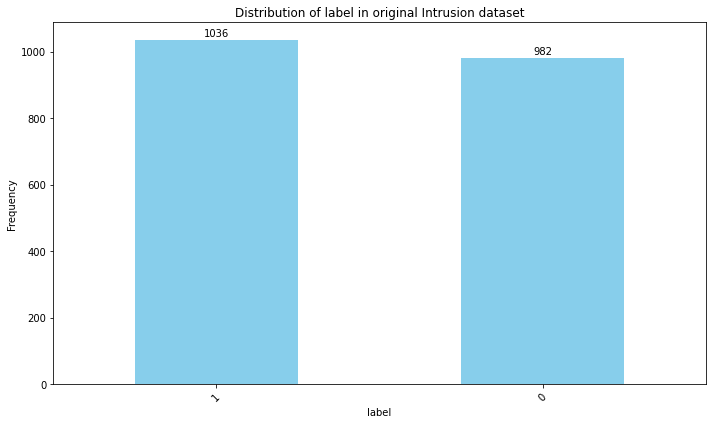

In [17]:
value_counts = train[label].value_counts()
plt.figure(figsize=(10, 6))
ax = value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of label in original Intrusion dataset')
plt.xlabel('label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center')
plt.tight_layout()
plt.show()

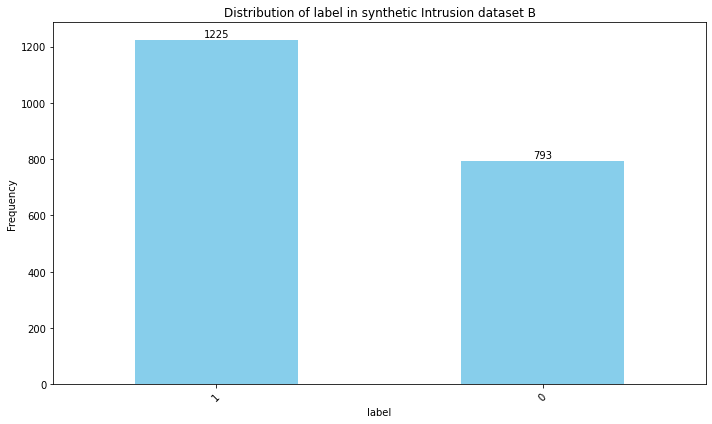

In [18]:
value_counts = result_1[label].value_counts()
plt.figure(figsize=(10, 6))
ax = value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of label in synthetic Intrusion dataset B')
plt.xlabel('label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center')
plt.tight_layout()
plt.show()

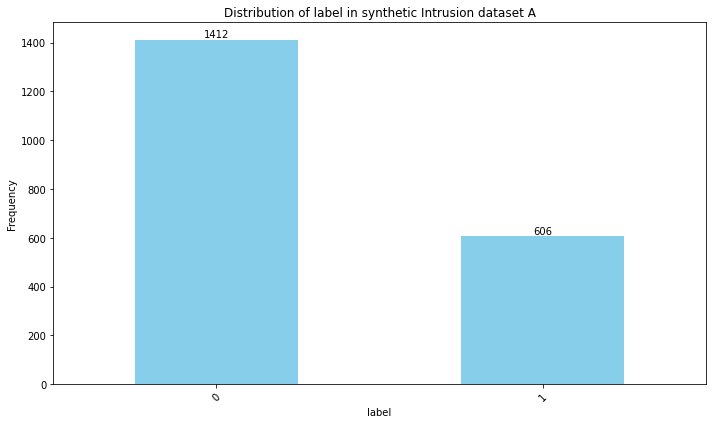

In [19]:
value_counts = result_2[label].value_counts()
plt.figure(figsize=(10, 6))
ax = value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of label in synthetic Intrusion dataset A')
plt.xlabel('label')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center')
plt.tight_layout()
plt.show()

### Compare the distribution

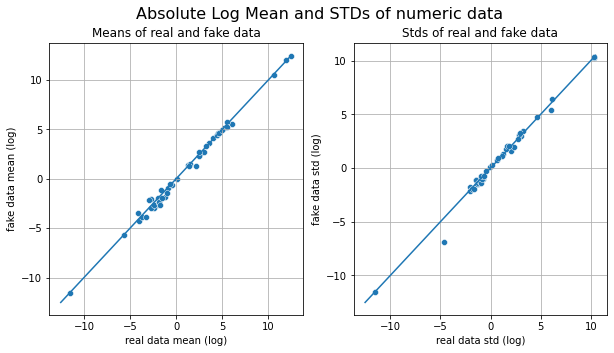

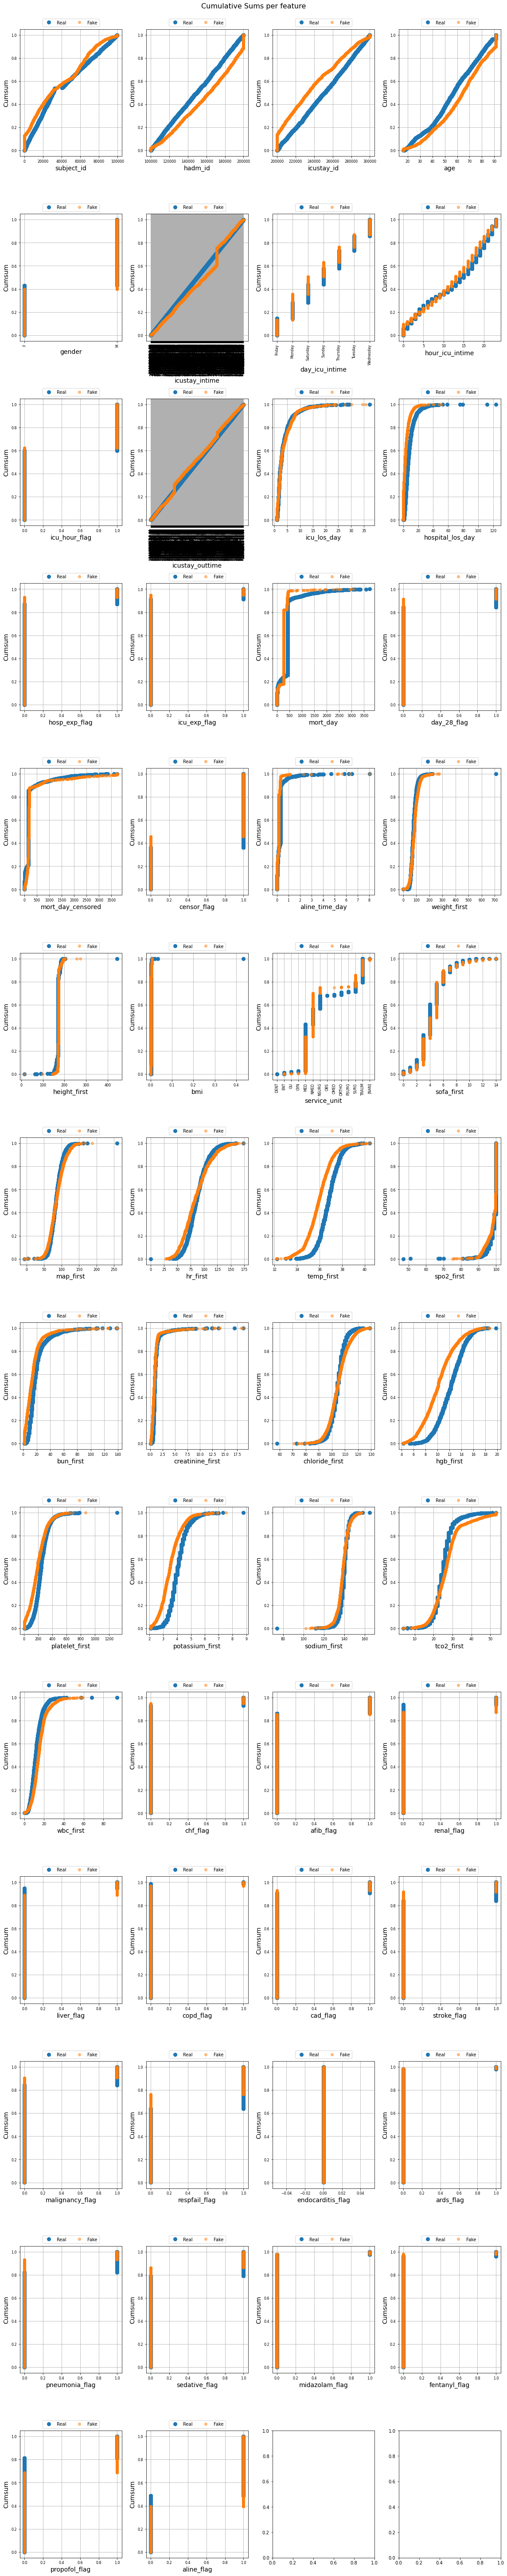

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\

LinAlgError: singular matrix

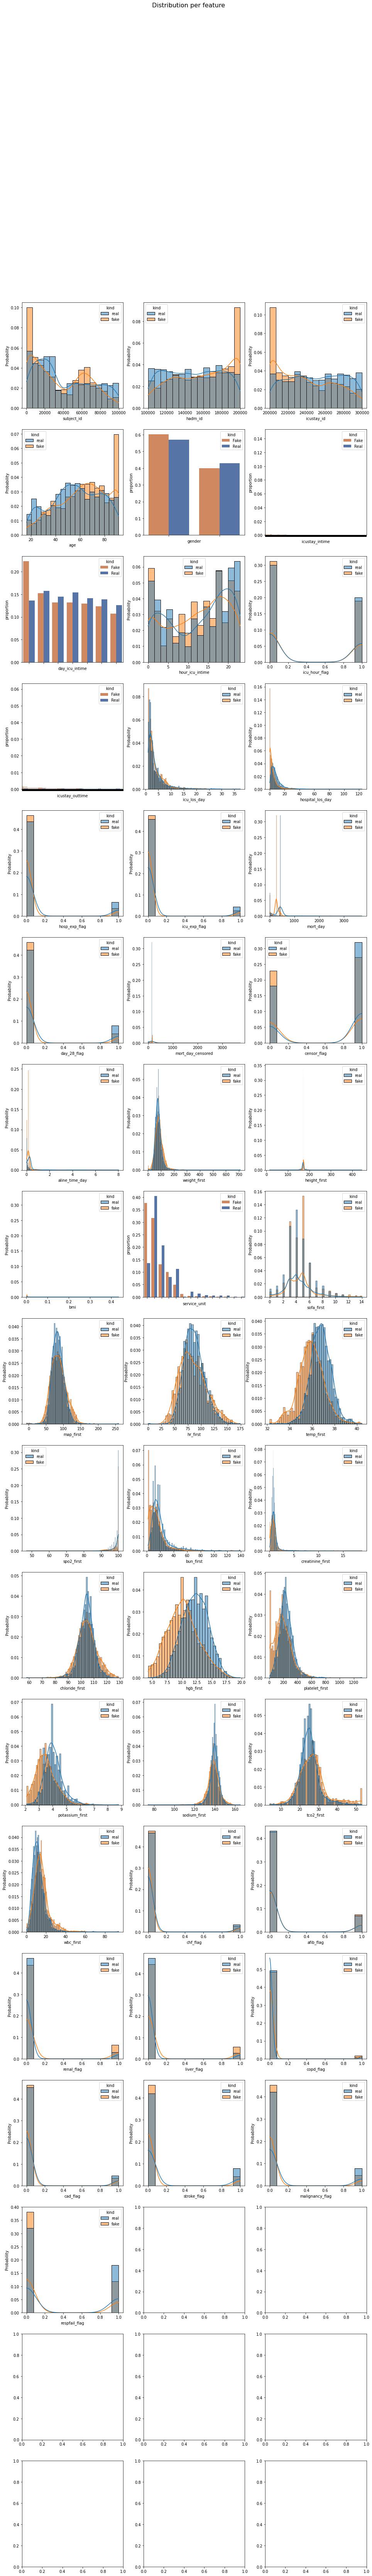

In [20]:
table_evaluator = TableEvaluator(train, result_1)
table_evaluator.visual_evaluation()

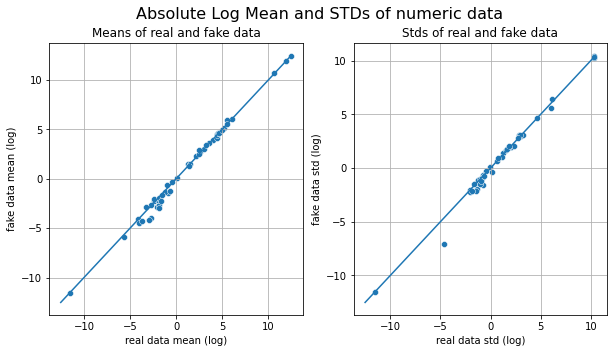

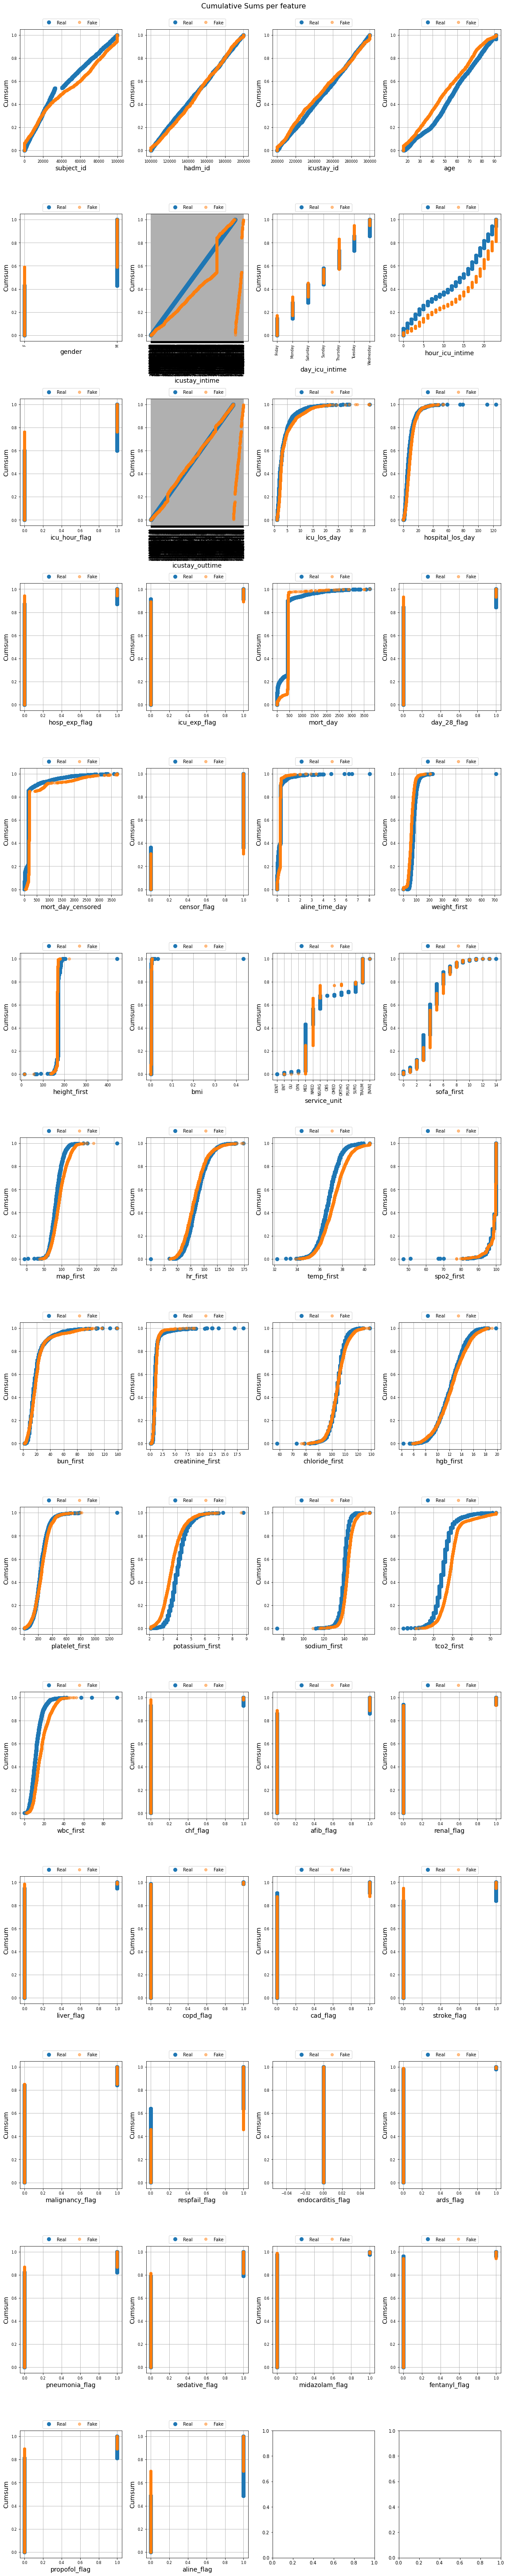

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\

LinAlgError: singular matrix

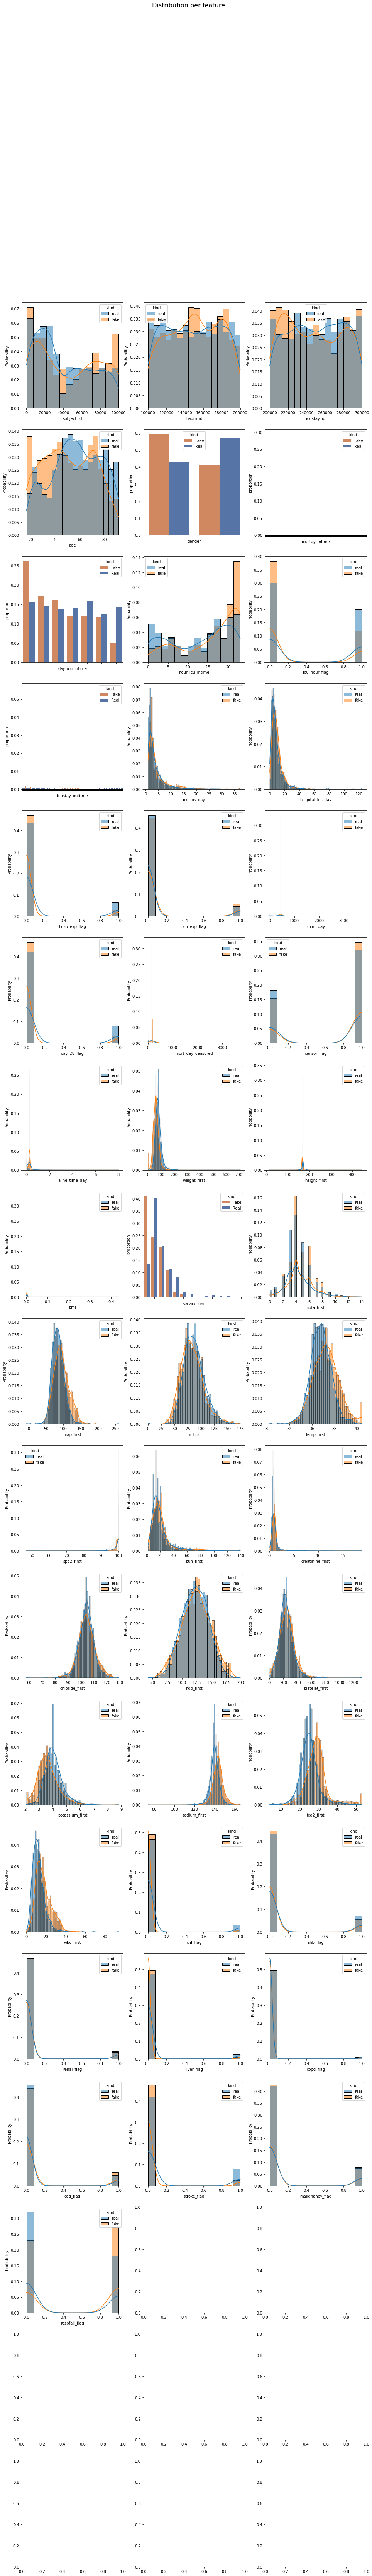

In [21]:
table_evaluator = TableEvaluator(train, result_2)
table_evaluator.visual_evaluation()